# 0. Importación de librerias + Google Drive

In [1]:
# Importación de librerias

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle
import os
import shap
from PIL import Image
from IPython.display import Image as IPImage, display
import traceback

print(f"SHAP version: {shap.__version__}")
shap.initjs() # Es importante inicializar JavaScript para las visualizaciones de SHAP en notebooks
print("SHAP importado y JavaScript inicializado.")

SHAP version: 0.47.2


SHAP importado y JavaScript inicializado.


In [2]:
# Montar Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Definición de ruta base en Google Drive

BASE_PATH = '/content/drive/MyDrive/Doctorado/XAI' # O en donde este el archivo y la BD
OUTPUT_PATH = os.path.join(BASE_PATH, 'Final_XAI_FA/')

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

# 1. Carga y Exploración Inicial del DataFrame de Atributos de FA

In [4]:
# Nombre del archivo CSV que contiene los atributos de FA

csv_filename = 'Atributos_FA_M4_833_kpb_KNN_E50_XGB_nb_sinr3_sinInf.csv'
attributes_file_path = os.path.join(BASE_PATH, csv_filename)

El archivo `Atributos_FA_M4_833_kpb_KNN_E50_XGB_nb_sinr3_sinInf.csv` contiene los atributos de FA extraídos de las señales después de pasar por los bloques de limpieza de ruido y ectópicos.

In [5]:
# Carga y Exploración Inicial del DataFrame de Atributos

try:
    df_attributes = pd.read_csv(attributes_file_path)
    print(f"Archivo CSV '{csv_filename}' cargado exitosamente.")
    print("\n--- Información del DataFrame ---")
    df_attributes.info() # Muestra tipos de datos y valores no nulos

    print("\n--- Primeras 5 filas del DataFrame ---")
    print(df_attributes.head())

    print("\n--- Nombres de las Columnas ---")
    print(df_attributes.columns.tolist())

    print("\n--- Valores Únicos en la Columna 'Ritmo' (para verificar etiquetas) ---")
    if 'Ritmo' in df_attributes.columns:
        print(df_attributes['Ritmo'].value_counts())
    else:
        print("Advertencia: La columna 'Ritmo' no se encontró para mostrar sus valores únicos.")

except FileNotFoundError:
    print(f"Error CRÍTICO: Archivo de atributos no encontrado en {attributes_file_path}")
    print("Por favor, verifica la ruta y el nombre del archivo.")
except Exception as e:
    print(f"Un error CRÍTICO inesperado ocurrió al cargar el CSV: {e}")

Archivo CSV 'Atributos_FA_M4_833_kpb_KNN_E50_XGB_nb_sinr3_sinInf.csv' cargado exitosamente.

--- Información del DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7578 entries, 0 to 7577
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  7578 non-null   int64  
 1   Ritmo       7578 non-null   object 
 2   P_cv        7578 non-null   float64
 3   P_RMSSD     7578 non-null   float64
 4   P_NMASD     7578 non-null   float64
 5   P_IPD       7578 non-null   float64
 6   P_SamEn     7578 non-null   float64
 7   P_SSamEn    7578 non-null   float64
 8   P_CSamEn    7578 non-null   float64
 9   P_ShEn      7578 non-null   float64
 10  P_NZPP_1    7578 non-null   int64  
 11  P_NZPP_2    7578 non-null   int64  
 12  P_NZPP_3    7578 non-null   int64  
 13  Pσ_y_0      7578 non-null   float64
 14  Pσ_y_1      7578 non-null   float64
 15  Pσ_ED       7578 non-null   float64
 16  PNN_50      7578 non-nu

## Introducción al Conjunto de Datos de Atributos

El dataset contiene **7578 muestras**, donde cada muestra representa una grabación de ECG (o un segmento significativo de ella) que ya ha sido procesada a través de bloques de eliminación de ruido (utilizando un clasificador KNN) y latidos ectopicos (utilizando un clasificador XGBoost).

Para cada una de estas muestras, se han calculado **17 características (features)** numéricas. Estas características, como `P_cv`, `P_RMSSD`, `P_NMASD`, entre otras, son índices derivados del análisis de la variabilidad del ritmo cardíaco (HRV) y la morfología del gráfico de Poincaré, diseñados para capturar la irregularidad y los patrones típicos asociados con diferentes ritmos cardíacos.

El objetivo principal es clasificar el **`Ritmo`** cardíaco. Las etiquetas de ritmo presentes en el dataset son:
* **N (Normal):** 4668 muestras
* **O (Otro Ritmo):** 2271 muestras
* **A (Fibrilación Auricular):** 639 muestras

Como se puede observar, existe un desbalance de clases, siendo la Fibrilación Auricular la clase minoritaria. Todas las características numéricas (features) están completas, sin valores nulos, lo que simplifica la etapa de preprocesamiento para el entrenamiento de modelos.

## Descripción de las Columnas del DataFrame de Atributos de FA

### Columnas Generales:

* **`Unnamed: 0`**:
    * **Representación:** Generalmente es un índice añadido automáticamente por Pandas al guardar y luego recargar un archivo CSV. No tiene significado fisiológico para el modelo.
    * **Uso:** Se ignora como feature.

* **`Ritmo`**:
    * **Representación:** Es la **etiqueta objetivo** que indica el tipo de ritmo cardíaco.
    * **Valores Comunes:** 'N' (Normal), 'A' (Fibrilación Auricular). Se mapea a `0` (No-FA) y `1` (FA) para el entrenamiento del modelo binario.
    * **Uso:** Es lo que el modelo intenta predecir.

---
### Índices de Variabilidad del Ritmo Cardíaco (HRV) y Análisis de Ritmo:

Estos índices se calculan (generalmente) a partir de la serie de intervalos NN (normal-a-normal), que son los intervalos RR después de la limpieza de ruido y ectópicos. Cuantifican diferentes aspectos de la regularidad y variabilidad del ritmo cardíaco.

* **`P_cv` (Coeficiente de Variación de los intervalos NN):**
    * **Representación:** `SDNN / MeanNN`. Medida normalizada de la dispersión de los intervalos NN.
    * **En FA:** Tiende a ser **mayor** debido a la alta irregularidad.

* **`P_RMSSD` (Raíz Cuadrada de la Media de las Diferencias al Cuadrado de Intervalos NN Sucesivos):**
    * **Representación:** Mide la variabilidad latido a latido a corto plazo.
    * **En FA:** Tiende a ser **mayor** debido a la alta variabilidad.

* **`P_NMASD` (Normalized Median Absolute Successive Difference o similar):**
    * **Representación:** Probablemente una medida de la dispersión de las diferencias absolutas entre latidos sucesivos, normalizada. La implementación en `utils.py` es `sum(abs(diff(serie))) / mean(serie)`.
    * **En FA:** Tiende a ser **mayor** debido a las grandes y variables diferencias entre latidos.

* **`P_IPD` (Índice de Diferencia de Puntos de Inflexión - "Turning Point Index"):**
    * **Representación:** Analiza la frecuencia y magnitud de los "puntos de inflexión" en la serie de intervalos NN (donde un intervalo es mayor o menor que sus dos vecinos).
    * **En FA:** Según la tesis, se espera que este índice sea **menor**.

* **`PNN_50`**:
    * **Representación:** Porcentaje de intervalos NN sucesivos que difieren en más de 50 ms.
    * **En FA:** Tiende a ser **mayor**.

* **`PNN_100`**:
    * **Representación:** Porcentaje de intervalos NN sucesivos que difieren en más de 100 ms.
    * **En FA:** Tiende a ser **mayor**.

---
### Medidas de Entropía y Complejidad:

Cuantifican la regularidad, previsibilidad o complejidad de la serie de intervalos NN.

* **`P_SamEn` (Entropía de Muestreo - Sample Entropy):**
    * **Representación:** Mide la regularidad de una serie temporal. Valores más altos indican mayor irregularidad/complejidad.
    * **En FA:** Tiende a ser **mayor**.

* **`P_SSamEn` (Entropía de Muestreo Simplificada - Simplified Sample Entropy):**
    * **Representación:** Una variante de la Entropía de Muestreo.
    * **En FA:** Tiende a ser **mayor**.

* **`P_CSamEn` (Coeficiente de Entropía de Muestreo):**
    * **Representación:** Una normalización o modificación de la Entropía de Muestreo.
    * **En FA:** Tiende a ser **mayor**.

* **`P_ShEn` (Entropía de Shannon - de la distribución de intervalos NN):**
    * **Representación:** Mide la incertidumbre o aleatoriedad en la distribución de los valores de los intervalos NN.
    * **En FA:** Tiende a ser **mayor** debido a una distribución más dispersa de los intervalos.

* **`P_Shan_2`**:
    * **Representación:** Probablemente una variante específica del cálculo de la Entropía de Shannon, como se usa en `AFClassifier.py` (posiblemente sobre una serie NN binarizada o con una discretización particular).
    * **En FA:** Tiende a ser **mayor**.

---
### Índices del Gráfico de Poincaré:

El gráfico de Poincaré (RR\_i vs RR\_{i+1}) visualiza la dinámica del ritmo.

* **`P_NZPP_1` (Número de Puntos No Cero en Poincaré - Versión 1: RRn vs RRn+1):**
    * **Representación:** Número de celdas no vacías en el histograma 2D del gráfico de Poincaré RRn vs RRn+1.
    * **En FA:** Tiende a ser **mayor** debido a la nube de puntos más dispersa.

* **`P_NZPP_2` (Número de Puntos No Cero en Poincaré - Versión 2: ΔRRn vs ΔRRn+1):**
    * **Representación:** Número de celdas no vacías en el Poincaré de diferencias de intervalos sucesivos. Sensible a la irregularidad.
    * **En FA:** Tiende a ser **mayor**.

* **`P_NZPP_3` (Número de Puntos No Cero en Poincaré - Versión 3: RRn vs ΔRRn):**
    * **Representación:** Número de celdas no vacías en el Poincaré de un intervalo vs. la diferencia con el siguiente.
    * **En FA:** Tiende a ser **mayor**.

* **`Pσ_y_0` (Desviación Estándar Normalizada en Poincaré Rotado - Eje y', similar a SD1):**
    * **Representación:** Mide la variabilidad a corto plazo, perpendicular a la línea de identidad en el Poincaré de RRn vs RRn+1 rotado 45 grados.
    * **En FA:** Tiende a ser **mayor**.

* **`Pσ_y_1` (Desviación Estándar Normalizada en Poincaré Rotado - Eje x', similar a SD2):**
    * **Representación:** Mide la variabilidad a largo plazo, paralela a la línea de identidad en el Poincaré de RRn vs RRn+1 rotado. (Nota: La tesis usa P\_sigma\_x,0 para SD2).
    * **En FA:** Tiende a ser **mayor**.

* **`Pσ_ED` (Distancia Euclidiana Media Normalizada de Puntos Sucesivos en Poincaré):**
    * **Representación:** Distancia promedio entre puntos adyacentes en la secuencia del gráfico de Poincaré.
    * **En FA:** Tiende a ser **mayor** debido a los saltos erráticos.

---

# 2. Definición de Features, Mapeo de Etiquetas, Balanceo y Preprocesamiento

In [6]:
# Definición de Features, Mapeo de Etiquetas, Balanceo y Preprocesamiento

# Verificar si df_attributes se cargó correctamente en la celda anterior
if 'df_attributes' not in locals() or df_attributes is None:
    print("Error: df_attributes no está definido. Ejecuta la Celda 2 primero para cargar los datos.")
else:
    try:
        # --- Identificación de Columnas de Features y Etiqueta ---
        label_col = 'Ritmo'

        all_possible_feature_cols = ['P_cv', 'P_RMSSD', 'P_NMASD', 'P_IPD', 'P_SamEn',
                                     'P_SSamEn', 'P_CSamEn', 'P_ShEn', 'P_NZPP_1',
                                     'P_NZPP_2', 'P_NZPP_3', 'Pσ_y_0', 'Pσ_y_1',
                                     'Pσ_ED', 'PNN_50', 'PNN_100', 'P_Shan_2']
        feature_cols = [col for col in all_possible_feature_cols if col in df_attributes.columns]

        if not feature_cols:
            raise ValueError("No se encontraron columnas de features esperadas en el CSV.")
        if label_col not in df_attributes.columns:
            raise ValueError(f"La columna de etiquetas '{label_col}' no se encontró en el CSV.")

        print(f"Usando columna de etiqueta: '{label_col}'")
        print(f"Usando columnas de features: {feature_cols}")

        # Crear copias para no modificar el DataFrame original directamente en esta etapa
        X_original = df_attributes[feature_cols].copy()
        y_original_labels = df_attributes[label_col].copy()

        # --- Mapeo de Etiquetas ---
        label_map = {'A': 1, 'N': 0, 'O': 0} # donde 'A' es FA (1), 'N' y 'O' son No-FA (0) (normales u otro tipo de ruidos)
        y_mapped = y_original_labels.map(label_map)

        # Combinar X y y_mapped temporalmente para filtrar NaNs y luego para el undersampling
        processed_df = X_original.copy()
        processed_df['label_mapped'] = y_mapped # Usamos un nombre temporal para la columna de etiquetas mapeadas

        if processed_df['label_mapped'].isnull().any():
            print("\nAdvertencia: Se encontraron NaNs en la columna de etiquetas después del mapeo.")
            print(f"Número de NaNs en etiquetas: {processed_df['label_mapped'].isnull().sum()}")
            processed_df.dropna(subset=['label_mapped'], inplace=True) # Eliminar filas con etiquetas NaN
            print(f"Filas restantes después de eliminar etiquetas NaN: {len(processed_df)}")

        if len(processed_df) == 0:
            raise ValueError("No quedaron datos después de procesar las etiquetas. Verifica el mapeo y las etiquetas originales.")

        print(f"\nDistribución de clases ANTES del balanceo (0=No-FA, 1=FA):\n{processed_df['label_mapped'].value_counts(normalize=True)}")
        print(f"Conteos absolutos ANTES del balanceo:\n{processed_df['label_mapped'].value_counts()}")


        # --- BALANCEO DE CLASES (Undersampling Manual) ---
        n_samples_per_class = 600 # Definimos 600 muestras por clase

        df_class_0 = processed_df[processed_df['label_mapped'] == 0]
        df_class_1 = processed_df[processed_df['label_mapped'] == 1]

        # Tomar n_samples_per_class de cada clase (o menos si no hay suficientes)
        # Usamos sample(frac=1) para barajar antes de tomar las primeras n, o sample(n=...) directamente si n es menor que el total
        df_class_0_sampled = df_class_0.sample(n=min(len(df_class_0), n_samples_per_class), random_state=42)
        df_class_1_sampled = df_class_1.sample(n=min(len(df_class_1), n_samples_per_class), random_state=42)

        # Concatenar los dataframes muestreados
        df_balanced = pd.concat([df_class_0_sampled, df_class_1_sampled])

        # Barajar el dataframe balanceado final
        df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

        print(f"\nDistribución de clases DESPUÉS del balanceo a {n_samples_per_class} por clase (0=No-FA, 1=FA):\n{df_balanced['label_mapped'].value_counts(normalize=True)}")
        print(f"Conteos absolutos DESPUÉS del balanceo:\n{df_balanced['label_mapped'].value_counts()}")

        # Separar X e y del dataframe balanceado
        X = df_balanced[feature_cols].copy()
        y = df_balanced['label_mapped'].copy()
        # --- FIN DEL BALANCEO ---


        # --- Preprocesamiento de Features (sobre el conjunto ya balanceado) ---
        nan_counts_before_imputation = X.isnull().sum()
        if nan_counts_before_imputation.sum() > 0:
            print("\nNaNs por columna de feature ANTES de la imputación (después del balanceo):")
            print(nan_counts_before_imputation[nan_counts_before_imputation > 0])
            X = X.fillna(X.mean())
            print("NaNs imputados con la media de cada columna.")
        else:
            print("\nNo se encontraron NaNs en las columnas de features (después del balanceo).")

        # Escalar features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X) # Ajustar el escalador CON los datos balanceados

        # Guardar el escalador
        scaler_filename = os.path.join(OUTPUT_PATH, 'mi_fa_xgboost_scaler_balanceado_modular.pkl')
        with open(scaler_filename, 'wb') as f:
            pickle.dump(scaler, f)
        print(f"\nEscalador (ajustado con datos balanceados) guardado en: {scaler_filename}")
        print("Preprocesamiento y balanceo completados. Variables X_scaled e y están listas.")

    except ValueError as ve:
        print(f"Error CRÍTICO de datos en Celda: {ve}")
    except Exception as e:
        print(f"Un error CRÍTICO inesperado ocurrió en Celda: {e}")

Usando columna de etiqueta: 'Ritmo'
Usando columnas de features: ['P_cv', 'P_RMSSD', 'P_NMASD', 'P_IPD', 'P_SamEn', 'P_SSamEn', 'P_CSamEn', 'P_ShEn', 'P_NZPP_1', 'P_NZPP_2', 'P_NZPP_3', 'Pσ_y_0', 'Pσ_y_1', 'Pσ_ED', 'PNN_50', 'PNN_100', 'P_Shan_2']

Distribución de clases ANTES del balanceo (0=No-FA, 1=FA):
label_mapped
0    0.915677
1    0.084323
Name: proportion, dtype: float64
Conteos absolutos ANTES del balanceo:
label_mapped
0    6939
1     639
Name: count, dtype: int64

Distribución de clases DESPUÉS del balanceo a 600 por clase (0=No-FA, 1=FA):
label_mapped
1    0.5
0    0.5
Name: proportion, dtype: float64
Conteos absolutos DESPUÉS del balanceo:
label_mapped
1    600
0    600
Name: count, dtype: int64

No se encontraron NaNs en las columnas de features (después del balanceo).

Escalador (ajustado con datos balanceados) guardado en: /content/drive/MyDrive/Doctorado/XAI/Final_XAI_FA/mi_fa_xgboost_scaler_balanceado_modular.pkl
Preprocesamiento y balanceo completados. Variables X_sc

___
## Exploración Inicial de la Distribución de PNN_50 y PNN_100


--- Explorando Distribuciones de PNN_50 y PNN_100 por 'Ritmo' Original (N, O, A) ---
Total de muestras en el dataset original: 7578
Distribución de la etiqueta 'Ritmo' en el dataset original:
Ritmo
N    0.615994
O    0.299683
A    0.084323
Name: proportion, dtype: float64

--- Estadísticas Descriptivas para PNN_50 (Original) por Ritmo (N, O, A) ---
        count      mean       std  min       25%       50%       75%       max
Ritmo                                                                         
A       639.0  0.336385  0.195883  0.0  0.193996  0.311111  0.423403  0.976744
N      4668.0  0.838697  0.170366  0.0  0.769231  0.906250  0.966667  0.991525
O      2271.0  0.731976  0.259260  0.0  0.592593  0.826087  0.941176  0.992754

--- Estadísticas Descriptivas para PNN_100 (Original) por Ritmo (N, O, A) ---
        count      mean       std       min       25%       50%       75%       max
Ritmo                                                                              
A     

<ipython-input-7-6ed54270b442>:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes_hist_orig_classes[0].legend(title='Ritmo Original')
<ipython-input-7-6ed54270b442>:78: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes_hist_orig_classes[1].legend(title='Ritmo Original')


Histogramas/KDEs por Ritmo (N,O,A) guardados en: /content/drive/MyDrive/Doctorado/XAI/Final_XAI_FA/PNN_distributions_original_N_O_A_hist_kde.png


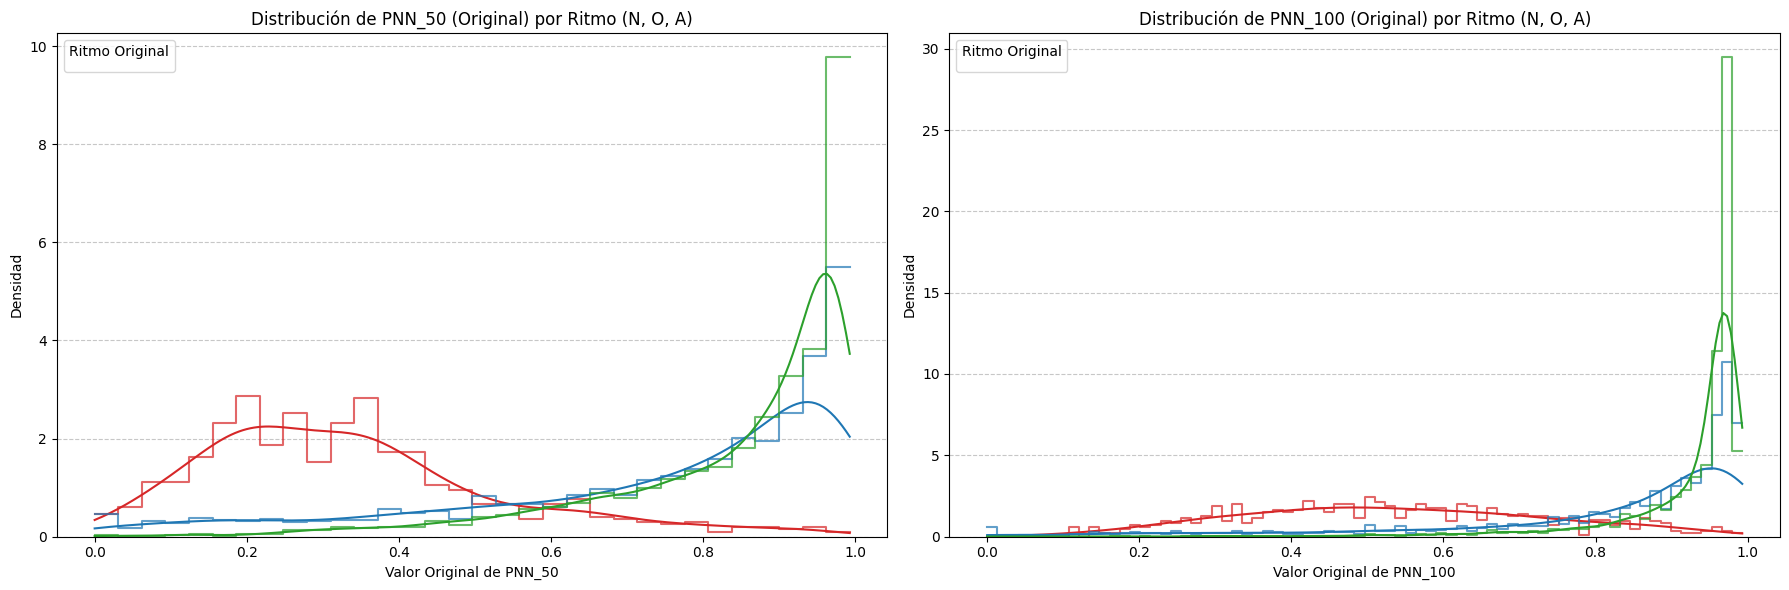


Generando Boxplots para PNN_50 y PNN_100 por Ritmo (N, O, A)...


<ipython-input-7-6ed54270b442>:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Ritmo', y='PNN_50', data=df_analysis_original_classes,
<ipython-input-7-6ed54270b442>:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Ritmo', y='PNN_100', data=df_analysis_original_classes,


Boxplots por Ritmo (N,O,A) guardados en: /content/drive/MyDrive/Doctorado/XAI/Final_XAI_FA/PNN_distributions_original_N_O_A_boxplots.png


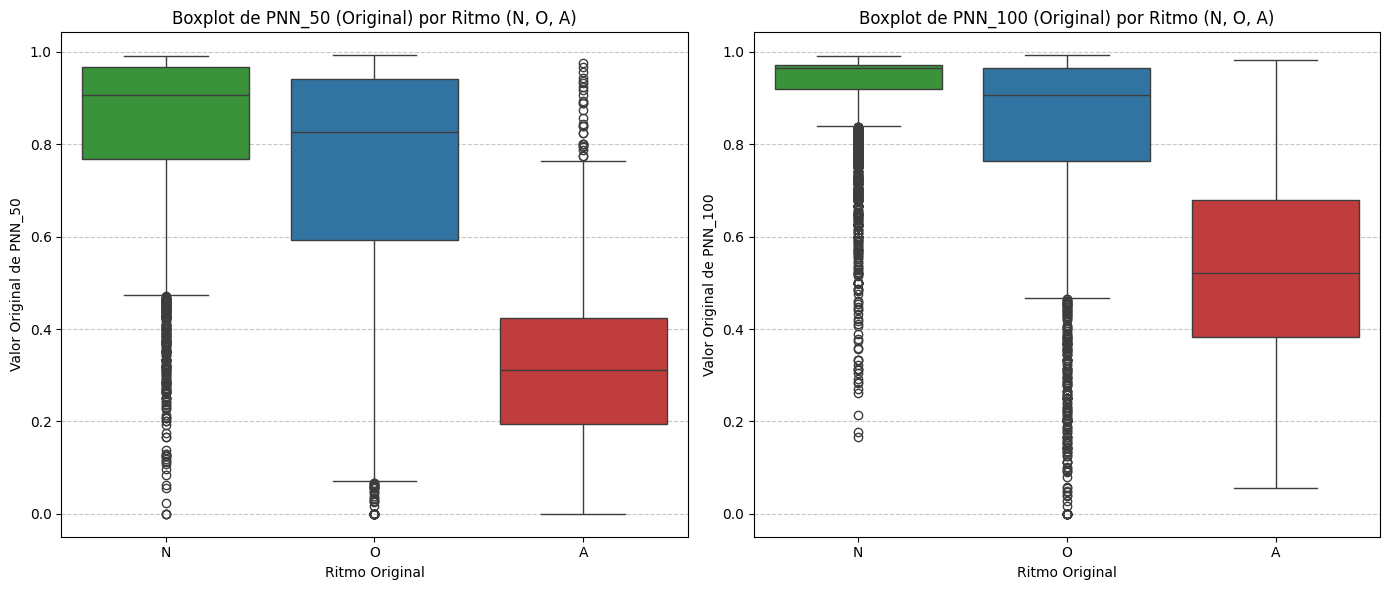

In [7]:
# Exploración de PNN_50 y PNN_100 por Etiqueta Original de Ritmo (N, O, A)

# Asegurarse de que df_attributes esté definido y contenga las columnas necesarias
if 'df_attributes' not in locals() or df_attributes is None:
    print("Error: El DataFrame 'df_attributes' no está definido. Ejecuta la celda de carga de datos primero.")
elif "PNN_50" not in df_attributes.columns or "PNN_100" not in df_attributes.columns:
    print("Error: Las columnas 'PNN_50' o 'PNN_100' no se encuentran en el DataFrame.")
elif 'Ritmo' not in df_attributes.columns:
    print("Error: La columna 'Ritmo' (para las etiquetas) no se encuentra en el DataFrame.")
else:
    try:
        # Verificar si OUTPUT_PATH está definido, si no, usar un directorio local temporal
        if 'OUTPUT_PATH' not in locals() or OUTPUT_PATH is None:
            OUTPUT_PATH = "temp_plots_output" # Directorio local temporal
            if not os.path.exists(OUTPUT_PATH):
                os.makedirs(OUTPUT_PATH)
            print(f"Advertencia: OUTPUT_PATH no estaba definido. Usando directorio local temporal: {OUTPUT_PATH}")


        print(f"\n--- Explorando Distribuciones de PNN_50 y PNN_100 por 'Ritmo' Original (N, O, A) ---")
        print(f"Total de muestras en el dataset original: {len(df_attributes)}")
        print(f"Distribución de la etiqueta 'Ritmo' en el dataset original:\n{df_attributes['Ritmo'].value_counts(normalize=True)}")

        # Usaremos directamente la columna 'Ritmo' para agrupar.
        df_analysis_original_classes = df_attributes[['PNN_50', 'PNN_100', 'Ritmo']].copy()

        # Filtrar por las clases de interés si es necesario (N, O, A)
        # Si 'Ritmo' solo contiene estas, no es estrictamente necesario, pero es buena práctica.
        valid_rhythms = ['N', 'O', 'A']
        df_analysis_original_classes = df_analysis_original_classes[df_analysis_original_classes['Ritmo'].isin(valid_rhythms)]

        if df_analysis_original_classes.empty:
            print("No hay datos disponibles para los ritmos 'N', 'O', 'A'.")
        else:
            # --- Estadísticas Descriptivas ---
            print("\n--- Estadísticas Descriptivas para PNN_50 (Original) por Ritmo (N, O, A) ---")
            stats_pnn50_orig = df_analysis_original_classes.groupby('Ritmo')['PNN_50'].describe()
            print(stats_pnn50_orig.to_string())

            print("\n--- Estadísticas Descriptivas para PNN_100 (Original) por Ritmo (N, O, A) ---")
            stats_pnn100_orig = df_analysis_original_classes.groupby('Ritmo')['PNN_100'].describe()
            print(stats_pnn100_orig.to_string())

            # --- Visualizaciones (Histogramas/KDEs y Boxplots) ---
            # Definir colores para cada ritmo
            # Puedes ajustar estos colores. Los tomo del ciclo por defecto de matplotlib.
            default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
            palette_original_classes = {
                'N': default_colors[2], # Verde
                'O': default_colors[0], # Azul
                'A': default_colors[3]  # Rojo
            }
            # Orden de las cohortes para los plots
            cohort_order_original = ['N', 'O', 'A']


            # --- 1. Histogramas Superpuestos con KDE ---
            print("\nGenerando Histogramas y KDEs para PNN_50 y PNN_100 por Ritmo (N, O, A)...")
            fig_hist_orig_classes, axes_hist_orig_classes = plt.subplots(1, 2, figsize=(18, 6))

            # PNN_50
            sns.histplot(data=df_analysis_original_classes, x='PNN_50', hue='Ritmo', hue_order=cohort_order_original,
                         kde=True, stat="density", common_norm=False, ax=axes_hist_orig_classes[0],
                         element="step", fill=False, alpha=0.7, palette=palette_original_classes)
            axes_hist_orig_classes[0].set_title('Distribución de PNN_50 (Original) por Ritmo (N, O, A)')
            axes_hist_orig_classes[0].set_xlabel('Valor Original de PNN_50')
            axes_hist_orig_classes[0].set_ylabel('Densidad')
            axes_hist_orig_classes[0].legend(title='Ritmo Original')
            axes_hist_orig_classes[0].grid(axis='y', linestyle='--', alpha=0.7)

            # PNN_100
            sns.histplot(data=df_analysis_original_classes, x='PNN_100', hue='Ritmo', hue_order=cohort_order_original,
                         kde=True, stat="density", common_norm=False, ax=axes_hist_orig_classes[1],
                         element="step", fill=False, alpha=0.7, palette=palette_original_classes)
            axes_hist_orig_classes[1].set_title('Distribución de PNN_100 (Original) por Ritmo (N, O, A)')
            axes_hist_orig_classes[1].set_xlabel('Valor Original de PNN_100')
            axes_hist_orig_classes[1].set_ylabel('Densidad')
            axes_hist_orig_classes[1].legend(title='Ritmo Original')
            axes_hist_orig_classes[1].grid(axis='y', linestyle='--', alpha=0.7)

            plt.tight_layout()
            hist_plot_orig_classes_filename = os.path.join(OUTPUT_PATH, 'PNN_distributions_original_N_O_A_hist_kde.png')
            plt.savefig(hist_plot_orig_classes_filename, dpi=300, bbox_inches='tight')
            print(f"Histogramas/KDEs por Ritmo (N,O,A) guardados en: {hist_plot_orig_classes_filename}")
            plt.show()

            # --- 2. Boxplots Comparativos ---
            print("\nGenerando Boxplots para PNN_50 y PNN_100 por Ritmo (N, O, A)...")
            fig_box_orig_classes, axes_box_orig_classes = plt.subplots(1, 2, figsize=(14, 6))

            # PNN_50
            sns.boxplot(x='Ritmo', y='PNN_50', data=df_analysis_original_classes,
                        ax=axes_box_orig_classes[0], palette=palette_original_classes, order=cohort_order_original)
            axes_box_orig_classes[0].set_title('Boxplot de PNN_50 (Original) por Ritmo (N, O, A)')
            axes_box_orig_classes[0].set_xlabel('Ritmo Original')
            axes_box_orig_classes[0].set_ylabel('Valor Original de PNN_50')
            axes_box_orig_classes[0].grid(axis='y', linestyle='--', alpha=0.7)

            # PNN_100
            sns.boxplot(x='Ritmo', y='PNN_100', data=df_analysis_original_classes,
                        ax=axes_box_orig_classes[1], palette=palette_original_classes, order=cohort_order_original)
            axes_box_orig_classes[1].set_title('Boxplot de PNN_100 (Original) por Ritmo (N, O, A)')
            axes_box_orig_classes[1].set_xlabel('Ritmo Original')
            axes_box_orig_classes[1].set_ylabel('Valor Original de PNN_100')
            axes_box_orig_classes[1].grid(axis='y', linestyle='--', alpha=0.7)

            plt.tight_layout()
            box_plot_orig_classes_filename = os.path.join(OUTPUT_PATH, 'PNN_distributions_original_N_O_A_boxplots.png')
            plt.savefig(box_plot_orig_classes_filename, dpi=300, bbox_inches='tight')
            print(f"Boxplots por Ritmo (N,O,A) guardados en: {box_plot_orig_classes_filename}")
            plt.show()

    except Exception as e:
        print(f"Un error CRÍTICO inesperado ocurrió: {e}")
        import traceback
        traceback.print_exc()


--- Explorando Distribuciones de PNN_50 y PNN_100 en el Dataset Original Completo ---
Total de muestras en el dataset original: 7578
Distribución de la etiqueta 'Ritmo' en el dataset original:
Ritmo
N    0.615994
O    0.299683
A    0.084323
Name: proportion, dtype: float64

Generando Histogramas y KDEs para PNN_50 y PNN_100 (Dataset Original)...


<ipython-input-8-91cb2ae03b72>:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes_hist_orig[0].legend(title='Cohorte Original')
<ipython-input-8-91cb2ae03b72>:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes_hist_orig[1].legend(title='Cohorte Original')


Histogramas/KDEs de PNN_50 y PNN_100 (Dataset Original) guardados en: /content/drive/MyDrive/Doctorado/XAI/Final_XAI_FA/PNN_distributions_original_dataset_hist_kde.png


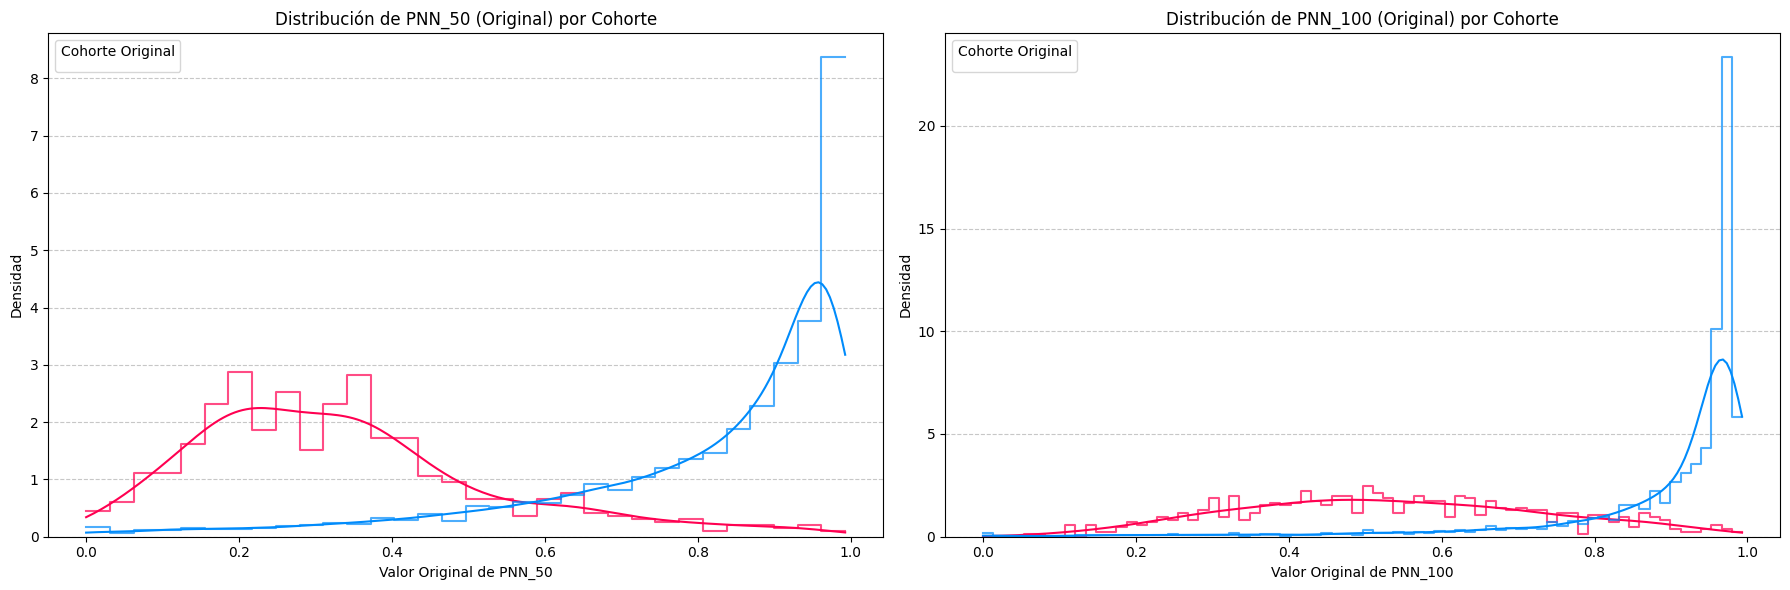


Generando Boxplots para PNN_50 y PNN_100 (Dataset Original) por cohorte...


<ipython-input-8-91cb2ae03b72>:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cohorte_Original', y='Valor_Original', data=data_pnn50_orig_for_boxplot,
<ipython-input-8-91cb2ae03b72>:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cohorte_Original', y='Valor_Original', data=data_pnn100_orig_for_boxplot,


Boxplots de PNN_50 y PNN_100 (Dataset Original) guardados en: /content/drive/MyDrive/Doctorado/XAI/Final_XAI_FA/PNN_distributions_original_dataset_boxplots.png


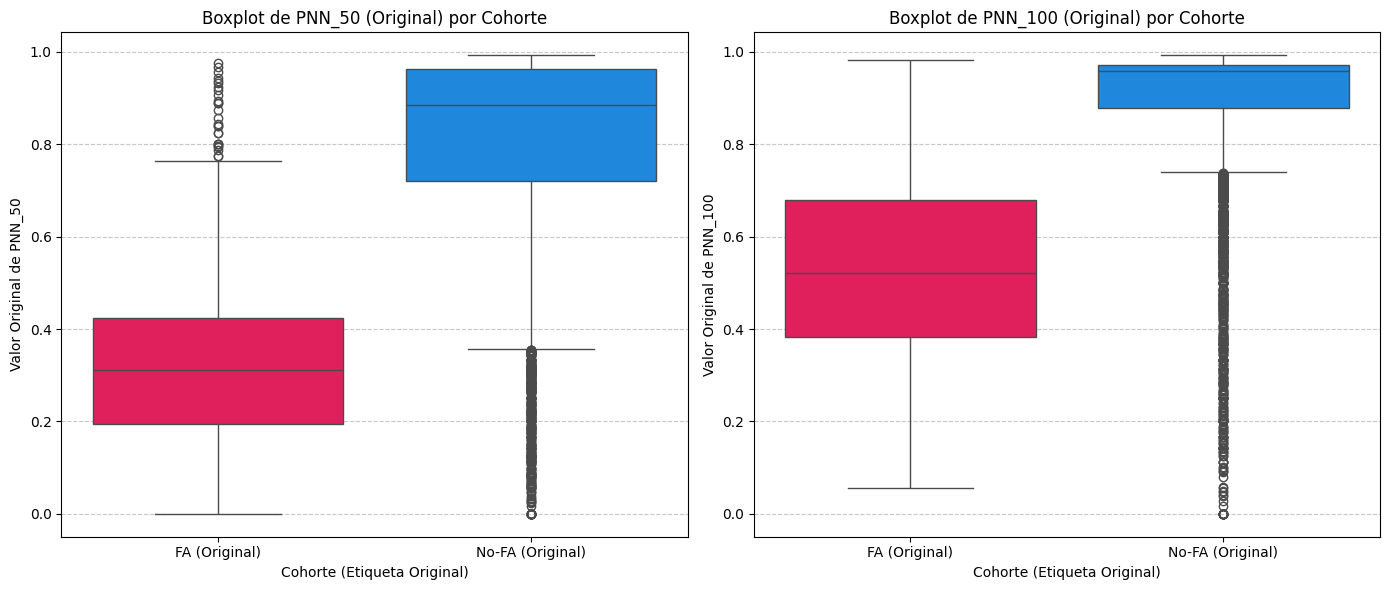

In [8]:
# Exploración Inicial de la Distribución de PNN_50 y PNN_100 (Dataset Original)

# Asegurarse de que df_attributes esté definido y contenga las columnas necesarias
if 'df_attributes' not in locals() or df_attributes is None:
    print("Error: El DataFrame 'df_attributes' no está definido. Ejecuta la celda de carga de datos primero.")
elif "PNN_50" not in df_attributes.columns or "PNN_100" not in df_attributes.columns:
    print("Error: Las columnas 'PNN_50' o 'PNN_100' no se encuentran en el DataFrame.")
elif 'Ritmo' not in df_attributes.columns:
    print("Error: La columna 'Ritmo' (para las etiquetas) no se encuentra en el DataFrame.")
else:
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
        import pandas as pd # Asegurar que pandas esté importado si no lo está globalmente

        print(f"\n--- Explorando Distribuciones de PNN_50 y PNN_100 en el Dataset Original Completo ---")
        print(f"Total de muestras en el dataset original: {len(df_attributes)}")
        print(f"Distribución de la etiqueta 'Ritmo' en el dataset original:\n{df_attributes['Ritmo'].value_counts(normalize=True)}")


        # --- Crear un DataFrame temporal para facilitar el ploteo con Seaborn ---
        # Mapear 'Ritmo' a una forma más legible para la leyenda si es necesario, o usarla directamente
        # Aquí usaremos el mapeo que ya tienes en tu notebook para consistencia (FA, No-FA)
        label_map_display = {'A': 'FA (Original)', 'N': 'No-FA (Original)', 'O': 'No-FA (Original)'}
        df_pnn_original = df_attributes[['PNN_50', 'PNN_100', 'Ritmo']].copy()
        df_pnn_original['Cohorte_Original'] = df_pnn_original['Ritmo'].map(label_map_display)

        # Filtrar para asegurar que solo tengamos las cohortes mapeadas (en caso de que haya otros valores en 'Ritmo')
        df_pnn_original.dropna(subset=['Cohorte_Original'], inplace=True)


        # --- 1. Histogramas Superpuestos con Estimación de Densidad del Kernel (KDE) ---
        print("\nGenerando Histogramas y KDEs para PNN_50 y PNN_100 (Dataset Original)...")

        # Definir colores para consistencia
        color_fa_orig = (255/255, 0/255, 81/255)  # Mismo color para FA
        color_nofa_orig = (0/255, 139/255, 251/255) # Mismo color para No-FA

        # Crear paleta de colores para seaborn basada en las cohortes presentes
        palette_original = {}
        if 'FA (Original)' in df_pnn_original['Cohorte_Original'].unique():
            palette_original['FA (Original)'] = color_fa_orig
        if 'No-FA (Original)' in df_pnn_original['Cohorte_Original'].unique():
            palette_original['No-FA (Original)'] = color_nofa_orig


        fig_hist_orig, axes_hist_orig = plt.subplots(1, 2, figsize=(18, 6))

        # PNN_50
        if not df_pnn_original[df_pnn_original['Cohorte_Original'] == 'FA (Original)']['PNN_50'].empty or \
           not df_pnn_original[df_pnn_original['Cohorte_Original'] == 'No-FA (Original)']['PNN_50'].empty:
            sns.histplot(data=df_pnn_original, x='PNN_50', hue='Cohorte_Original',
                         kde=True, stat="density", common_norm=False, ax=axes_hist_orig[0],
                         element="step", fill=False, alpha=0.7, palette=palette_original if palette_original else None)
            axes_hist_orig[0].set_title('Distribución de PNN_50 (Original) por Cohorte')
            axes_hist_orig[0].set_xlabel('Valor Original de PNN_50')
            axes_hist_orig[0].set_ylabel('Densidad')
            if palette_original: # Solo mostrar leyenda si hay datos y paleta
                 axes_hist_orig[0].legend(title='Cohorte Original')
            axes_hist_orig[0].grid(axis='y', linestyle='--', alpha=0.7)
        else:
            axes_hist_orig[0].set_title('PNN_50: No hay datos suficientes en cohortes')


        # PNN_100
        if not df_pnn_original[df_pnn_original['Cohorte_Original'] == 'FA (Original)']['PNN_100'].empty or \
           not df_pnn_original[df_pnn_original['Cohorte_Original'] == 'No-FA (Original)']['PNN_100'].empty:
            sns.histplot(data=df_pnn_original, x='PNN_100', hue='Cohorte_Original',
                         kde=True, stat="density", common_norm=False, ax=axes_hist_orig[1],
                         element="step", fill=False, alpha=0.7, palette=palette_original if palette_original else None)
            axes_hist_orig[1].set_title('Distribución de PNN_100 (Original) por Cohorte')
            axes_hist_orig[1].set_xlabel('Valor Original de PNN_100')
            axes_hist_orig[1].set_ylabel('Densidad')
            if palette_original: # Solo mostrar leyenda si hay datos y paleta
                axes_hist_orig[1].legend(title='Cohorte Original')
            axes_hist_orig[1].grid(axis='y', linestyle='--', alpha=0.7)
        else:
            axes_hist_orig[1].set_title('PNN_100: No hay datos suficientes en cohortes')


        plt.tight_layout()
        hist_plot_orig_filename = os.path.join(OUTPUT_PATH, 'PNN_distributions_original_dataset_hist_kde.png')
        plt.savefig(hist_plot_orig_filename, dpi=300, bbox_inches='tight')
        print(f"Histogramas/KDEs de PNN_50 y PNN_100 (Dataset Original) guardados en: {hist_plot_orig_filename}")
        plt.show()


        # --- 2. Boxplots Comparativos (Dataset Original) ---
        print("\nGenerando Boxplots para PNN_50 y PNN_100 (Dataset Original) por cohorte...")

        fig_box_orig, axes_box_orig = plt.subplots(1, 2, figsize=(14, 6))

        # PNN_50
        data_pnn50_orig_for_boxplot = df_pnn_original[['PNN_50', 'Cohorte_Original']].copy()
        data_pnn50_orig_for_boxplot.rename(columns={'PNN_50': 'Valor_Original'}, inplace=True) # Para consistencia en y-label

        if not data_pnn50_orig_for_boxplot.empty and len(data_pnn50_orig_for_boxplot['Cohorte_Original'].unique()) > 0 :
            sns.boxplot(x='Cohorte_Original', y='Valor_Original', data=data_pnn50_orig_for_boxplot,
                        ax=axes_box_orig[0], palette=palette_original if palette_original else None,
                        order=['FA (Original)', 'No-FA (Original)'] if 'FA (Original)' in palette_original and 'No-FA (Original)' in palette_original else None)
            axes_box_orig[0].set_title('Boxplot de PNN_50 (Original) por Cohorte')
            axes_box_orig[0].set_xlabel('Cohorte (Etiqueta Original)')
            axes_box_orig[0].set_ylabel('Valor Original de PNN_50')
            axes_box_orig[0].grid(axis='y', linestyle='--', alpha=0.7)
        else:
            axes_box_orig[0].set_title('PNN_50: No hay datos suficientes')


        # PNN_100
        data_pnn100_orig_for_boxplot = df_pnn_original[['PNN_100', 'Cohorte_Original']].copy()
        data_pnn100_orig_for_boxplot.rename(columns={'PNN_100': 'Valor_Original'}, inplace=True)

        if not data_pnn100_orig_for_boxplot.empty and len(data_pnn100_orig_for_boxplot['Cohorte_Original'].unique()) > 0:
            sns.boxplot(x='Cohorte_Original', y='Valor_Original', data=data_pnn100_orig_for_boxplot,
                        ax=axes_box_orig[1], palette=palette_original if palette_original else None,
                        order=['FA (Original)', 'No-FA (Original)'] if 'FA (Original)' in palette_original and 'No-FA (Original)' in palette_original else None)
            axes_box_orig[1].set_title('Boxplot de PNN_100 (Original) por Cohorte')
            axes_box_orig[1].set_xlabel('Cohorte (Etiqueta Original)')
            axes_box_orig[1].set_ylabel('Valor Original de PNN_100')
            axes_box_orig[1].grid(axis='y', linestyle='--', alpha=0.7)
        else:
            axes_box_orig[1].set_title('PNN_100: No hay datos suficientes')


        plt.tight_layout()
        box_plot_orig_filename = os.path.join(OUTPUT_PATH, 'PNN_distributions_original_dataset_boxplots.png')
        plt.savefig(box_plot_orig_filename, dpi=300, bbox_inches='tight')
        print(f"Boxplots de PNN_50 y PNN_100 (Dataset Original) guardados en: {box_plot_orig_filename}")
        plt.show()

    except Exception as e:
        print(f"Un error CRÍTICO inesperado ocurrió al visualizar distribuciones PNN del dataset original: {e}")
        import traceback
        traceback.print_exc()

El análisis exploratorio de las distribuciones de las features `PNN_50` y `PNN_100` en el conjunto de datos de atributos original (antes del balanceo de clases y la división en conjuntos de entrenamiento/prueba) revela un patrón distintivo. Contrario a la expectativa teórica general de que los valores de `PNN_50` y `PNN_100` (que indican el porcentaje de diferencias grandes entre intervalos NN sucesivos) serían mayores en Fibrilación Auricular (FA) debido a su inherente irregularidad, los datos muestran una tendencia opuesta.

Para `PNN_50`, la media en las 639 muestras de "FA (Original)" es de 0.336 (mediana 0.311), mientras que para las 6939 muestras de "No-FA (Original)" es significativamente mayor, con una media de 0.804 (mediana 0.886). De manera similar, para `PNN_100`, las muestras de "FA (Original)" presentan una media de 0.533 (mediana 0.521), en contraste con las muestras de "No-FA (Original)" que tienen una media de 0.889 (mediana 0.958).

Estas estadísticas descriptivas indican que, en el dataset de atributos con el que se entrena el modelo, las instancias etiquetadas como FA ya presentan, en promedio, valores considerablemente más bajos para `PNN_50` y `PNN_100` que las instancias No-FA. Este comportamiento "inverso" a la teoría univariada simple es, por lo tanto, una característica inherente de los datos de entrada al modelo. Consecuentemente, es lógico que el modelo XGBoost haya aprendido a asociar valores más bajos de `PNN_50` y `PNN_100` con una mayor probabilidad de FA, y viceversa, como se observó consistentemente en los análisis de SHAP. Esta relación, ya presente en los datos de atributos originales, es probablemente el resultado del pipeline de preprocesamiento aplicado a las señales ECG crudas antes del cálculo de estas features.

# 3. División de Datos y Entrenamiento del Modelo XGBoost

In [9]:
# División de Datos y Entrenamiento del Modelo XGBoost

# Verificar si X_scaled e y están definidos de la celda anterior
if 'X_scaled' not in locals() or 'y' not in locals():
    print("Error: X_scaled o y no están definidos. Ejecuta la Celda 3 primero.")
else:
    try:
        # --- División en Conjuntos de Entrenamiento y Prueba ---
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42, stratify=y)

        print(f"\nTamaño del conjunto de entrenamiento: {X_train.shape[0]}")
        print(f"Tamaño del conjunto de prueba: {X_test.shape[0]}")
        if X_train.shape[0] == 0 or X_test.shape[0] == 0:
            raise ValueError("Conjunto de entrenamiento o prueba vacío. Revisa el procesamiento de datos.")

        # --- Considerar el Desbalance de Clases (scale_pos_weight) ---
        count_negative = np.sum(y_train == 0)
        count_positive = np.sum(y_train == 1)
        if count_positive == 0: # Evitar división por cero
            scale_pos_weight_value = 1 # O manejar de otra forma si no hay positivos en el training set
            print("Advertencia: No hay muestras positivas en el conjunto de entrenamiento. scale_pos_weight se establece en 1.")
        else:
            scale_pos_weight_value = count_negative / count_positive
        print(f"Calculated scale_pos_weight para XGBoost: {scale_pos_weight_value:.2f}")


        # --- Entrenamiento del Modelo XGBoost ---
        xgb_clf = xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            use_label_encoder=False, # Configuración moderna de XGBoost
            random_state=42,
            scale_pos_weight=scale_pos_weight_value # Para manejar desbalance de clases
        )
        xgb_clf.fit(X_train, y_train)
        print("\nModelo XGBoost entrenado.")

        # Guardar modelo entrenado
        model_filename = os.path.join(OUTPUT_PATH, 'mi_clasificador_FA_XGBoost_desde_attrs_modular.json')
        xgb_clf.save_model(model_filename)
        print(f"Modelo guardado en: {model_filename}")
        print("Entrenamiento completado. Modelo xgb_clf está listo.")

    except ValueError as ve:
        print(f"Error CRÍTICO de datos en Celda: {ve}")
    except Exception as e:
        print(f"Un error CRÍTICO inesperado ocurrió en Celda: {e}")


Tamaño del conjunto de entrenamiento: 900
Tamaño del conjunto de prueba: 300
Calculated scale_pos_weight para XGBoost: 1.00

Modelo XGBoost entrenado.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:30:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Modelo guardado en: /content/drive/MyDrive/Doctorado/XAI/Final_XAI_FA/mi_clasificador_FA_XGBoost_desde_attrs_modular.json
Entrenamiento completado. Modelo xgb_clf está listo.


# 4. Evaluación del Modelo


--- Evaluación del Modelo XGBoost (desde atributos pre-calculados) ---
Accuracy: 0.9033

Classification Report:
              precision    recall  f1-score   support

   No-FA (0)       0.89      0.92      0.90       150
      FA (1)       0.92      0.89      0.90       150

    accuracy                           0.90       300
   macro avg       0.90      0.90      0.90       300
weighted avg       0.90      0.90      0.90       300


Confusion Matrix:
[[138  12]
 [ 17 133]]


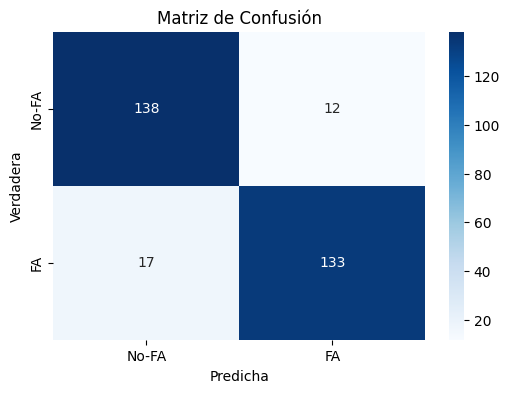


Evaluación completada.


In [11]:
# Evaluación del Modelo

# Verificar si xgb_clf, X_test, y_test están definidos
if 'xgb_clf' not in locals() or 'X_test' not in locals() or 'y_test' not in locals():
    print("Error: xgb_clf, X_test o y_test no están definidos. Ejecuta la Celda 4 primero.")
else:
    try:
        # --- Evaluación del Modelo ---
        y_pred = xgb_clf.predict(X_test)
        y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

        print("\n--- Evaluación del Modelo XGBoost (desde atributos pre-calculados) ---")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=['No-FA (0)', 'FA (1)']))
        print("\nConfusion Matrix:")
        cm = confusion_matrix(y_test, y_pred)
        print(cm)

        # Opcional: Visualización de la Matriz de Confusión
        plt.figure(figsize=(6,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No-FA', 'FA'], yticklabels=['No-FA', 'FA'])
        plt.xlabel('Predicha')
        plt.ylabel('Verdadera')
        plt.title('Matriz de Confusión')
        plt.show()
        print("\nEvaluación completada.")

    except Exception as e:
        print(f"Un error CRÍTICO inesperado ocurrió en Celda 5 durante la evaluación: {e}")

# 5. Creación del Explicador SHAP y Cálculo de Valores SHAP

In [12]:
# Creación del Explicador SHAP y Cálculo de Valores SHAP

# Verifica si xgb_clf, X_train, y X_test (o X_scaled antes de la división) están definidos
if 'xgb_clf' not in locals() or 'X_train' not in locals() or 'X_test' not in locals() or 'feature_cols' not in locals():
    print("Error: xgb_clf, X_train, X_test, o feature_cols no están definidos.")
    print("Asegúrate de haber ejecutado las celdas anteriores, especialmente la de entrenamiento.")
    print("Para TreeExplainer, usualmente se pasa el conjunto de entrenamiento para el 'background dataset'.")
else:
    try:
        # 1. Crear un objeto Explicador SHAP para modelos basados en árboles como XGBoost
        # TreeExplainer es eficiente para modelos de árbol.
        # Se le pasa el modelo y un "background dataset" (usualmente X_train) para ayudar a calcular las expectativas.
        explainer = shap.TreeExplainer(xgb_clf, data=X_train, feature_names=feature_cols, model_output="probability")

        # 2. Calcular los valores SHAP para tu conjunto de prueba (X_test)
        # X_test debe ser el conjunto de datos escalado que se uso para las predicciones y debe estar en el mismo formato (DataFrame o NumPy array) con el que se entrenó el modelo.
        # Si X_test es un NumPy array (como X_scaled), es bueno pasar feature_names.
        # Si X_test fuera un DataFrame de Pandas con nombres de columnas, SHAP podría inferirlos.
        shap_values_test = explainer.shap_values(X_test) # Para clasificación binaria, esto da los valores para la clase positiva

        # Para clasificadores XGBoost binarios, explainer.shap_values(X) devuelve un array de los valores SHAP para la clase positiva (clase 1).
        # Si fuera multiclase, devolvería una lista de arrays (uno por clase).

        print("Valores SHAP calculados para el conjunto de prueba.")
        print(f"Forma de los valores SHAP: {shap_values_test.shape}")
        print(f"Forma de X_test: {X_test.shape}")
        # La forma de shap_values_test debe ser (n_muestras_test, n_features)

        # Es útil convertir X_test (que es X_scaled_test) a un DataFrame de Pandas con los nombres de las columnas para las visualizaciones de SHAP, si aún no lo es.
        # Si X_test ya es un DataFrame con los nombres correctos, este paso no es necesario.
        # Asumimos que 'feature_cols' tiene los nombres originales de las features.
        X_test_df_for_shap = pd.DataFrame(X_test, columns=feature_cols)


    except Exception as e:
        print(f"Un error CRÍTICO inesperado ocurrió en Celda al calcular los valores SHAP: {e}")

Valores SHAP calculados para el conjunto de prueba.
Forma de los valores SHAP: (300, 17)
Forma de X_test: (300, 17)


Para cada predicción individual y para cada feature, SHAP calcula un valor que representa cuánto contribuyó esa feature a empujar la predicción desde un valor base (la predicción promedio del modelo sobre el conjunto de datos de entrenamiento) hasta la predicción final para esa instancia.

* **Valores SHAP positivos**: Indican que la feature empujó la predicción hacia la clase positiva (FA = 1).
* **Valores SHAP negativos**: Indican que la feature empujó la predicción hacia la clase negativa (No-FA = 0).
* **Magnitud del valor SHAP**: Cuanto mayor sea el valor absoluto del valor SHAP, mayor será el impacto de esa feature en esa predicción específica.

Para comprender en profundidad el comportamiento de nuestro modelo XGBoost entrenado para la detección de Fibrilación Auricular (FA), no basta con conocer su rendimiento general. Es crucial poder interpretar cómo toma sus decisiones. Utilizaremos los valores SHAP (SHapley Additive exPlanations) para lograr esta interpretabilidad desde dos perspectivas complementarias.

Primero, exploraremos las explicaciones globales, que nos permitirán identificar qué características (features) son las más importantes en promedio para el modelo y cómo tienden a influir en las predicciones a lo largo de todo el conjunto de datos. Posteriormente, nos adentraremos en las explicaciones locales, analizando instancias individuales para entender con precisión qué factores específicos llevaron al modelo a emitir una predicción particular para un caso dado. Esta combinación de análisis global y local nos proporcionará una visión integral y confiable del funcionamiento interno del clasificador.

# 6. Visualizaciones Globales de SHAP (Importancia de Features)


--- Gráfico de Resumen (Summary Plot - Beeswarm) ---
Beeswarm plot guardado en: /content/drive/MyDrive/Doctorado/XAI/Final_XAI_FA/SHAP_global_beeswarm_plot.png


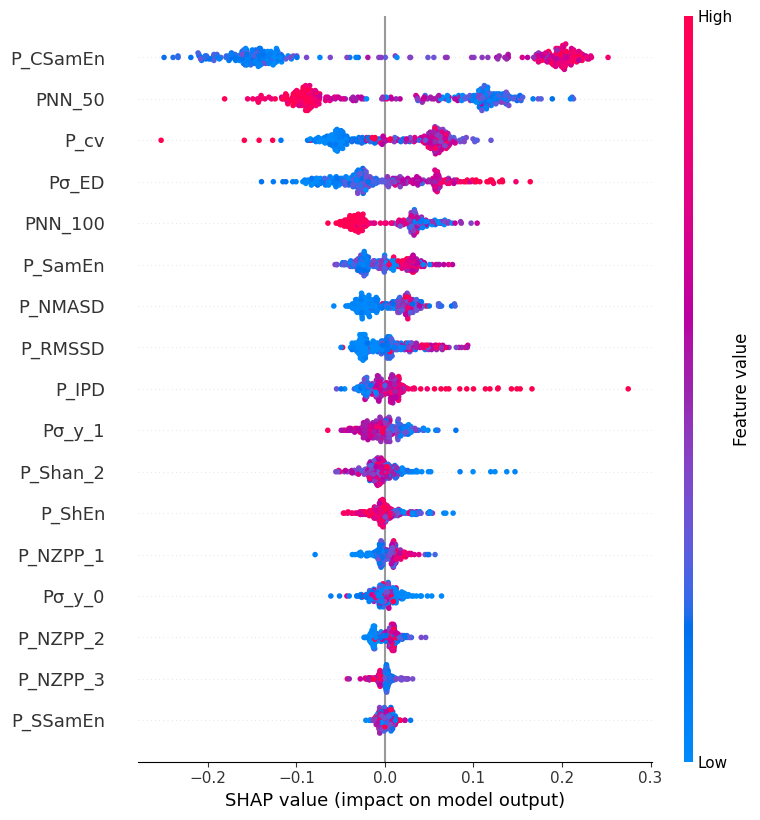


--- Gráfico de Barras de Importancia Global de Features ---
Barplot de importancia global guardado en: /content/drive/MyDrive/Doctorado/XAI/Final_XAI_FA/SHAP_global_barplot.png


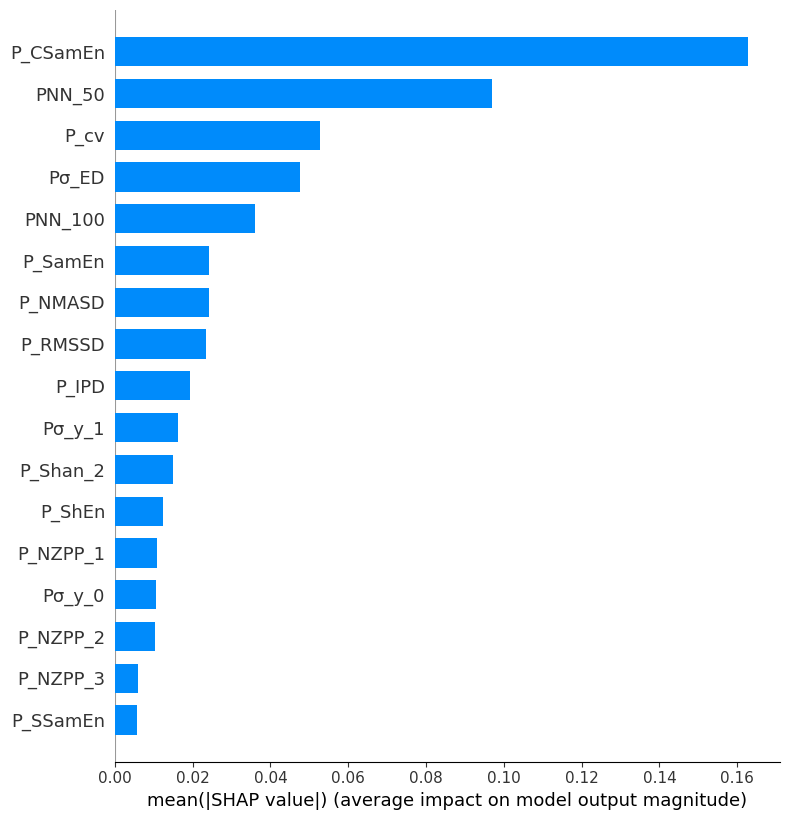

In [13]:
# Visualizaciones Globales de SHAP (Importancia de Features)

# Verificar si shap_values_test y X_test_df_for_shap están definidos
if 'shap_values_test' not in locals() or 'X_test_df_for_shap' not in locals():
    print("Error: shap_values_test o X_test_df_for_shap no están definidos. Ejecuta la Celda anterior primero.")
else:
    try:
        print("\n--- Gráfico de Resumen (Summary Plot - Beeswarm) ---")
        # Muestra el impacto de cada feature en la predicción para cada muestra.
        # Cada punto es una muestra, el color indica el valor del feature (alto/bajo).
        shap.summary_plot(shap_values_test, X_test_df_for_shap, plot_type="dot", show=False) # "dot" es el beeswarm, show=False

        # Guardar el Beeswarm plot
        beeswarm_plot_filename = os.path.join(OUTPUT_PATH, 'SHAP_global_beeswarm_plot.png')
        plt.savefig(beeswarm_plot_filename, dpi=300, bbox_inches='tight')
        print(f"Beeswarm plot guardado en: {beeswarm_plot_filename}")
        plt.show() # Ahora muestra el plot

        print("\n--- Gráfico de Barras de Importancia Global de Features ---")
        # Muestra la importancia media absoluta de cada feature.
        shap.summary_plot(shap_values_test, X_test_df_for_shap, plot_type="bar", show=False) # show=False

        # Guardar el Bar plot
        barplot_filename = os.path.join(OUTPUT_PATH, 'SHAP_global_barplot.png')
        plt.savefig(barplot_filename, dpi=300, bbox_inches='tight')
        print(f"Barplot de importancia global guardado en: {barplot_filename}")
        plt.show() # Ahora muestra el plot

    except Exception as e:
        print(f"Un error CRÍTICO inesperado ocurrió en Celda durante la visualización global: {e}")
        import traceback
        traceback.print_exc()


--- Análisis SHAP Global: Beeswarm Plots por Cohorte de Etiqueta Verdadera (Lado a Lado) ---

Generando Gráfico Beeswarm SHAP para VERDADERAS FA (150 muestras)...
Beeswarm plot temporal para Verdaderas FA guardado en: /content/drive/MyDrive/Doctorado/XAI/Final_XAI_FA/SHAP_beeswarm_cohorte_FA_true_temp.png

Generando Gráfico Beeswarm SHAP para VERDADERAS No-FA (150 muestras)...
Beeswarm plot temporal para Verdaderas No-FA guardado en: /content/drive/MyDrive/Doctorado/XAI/Final_XAI_FA/SHAP_beeswarm_cohorte_NoFA_true_temp.png

Beeswarm plots combinados guardados en: /content/drive/MyDrive/Doctorado/XAI/Final_XAI_FA/SHAP_beeswarm_cohortes_combinado.png


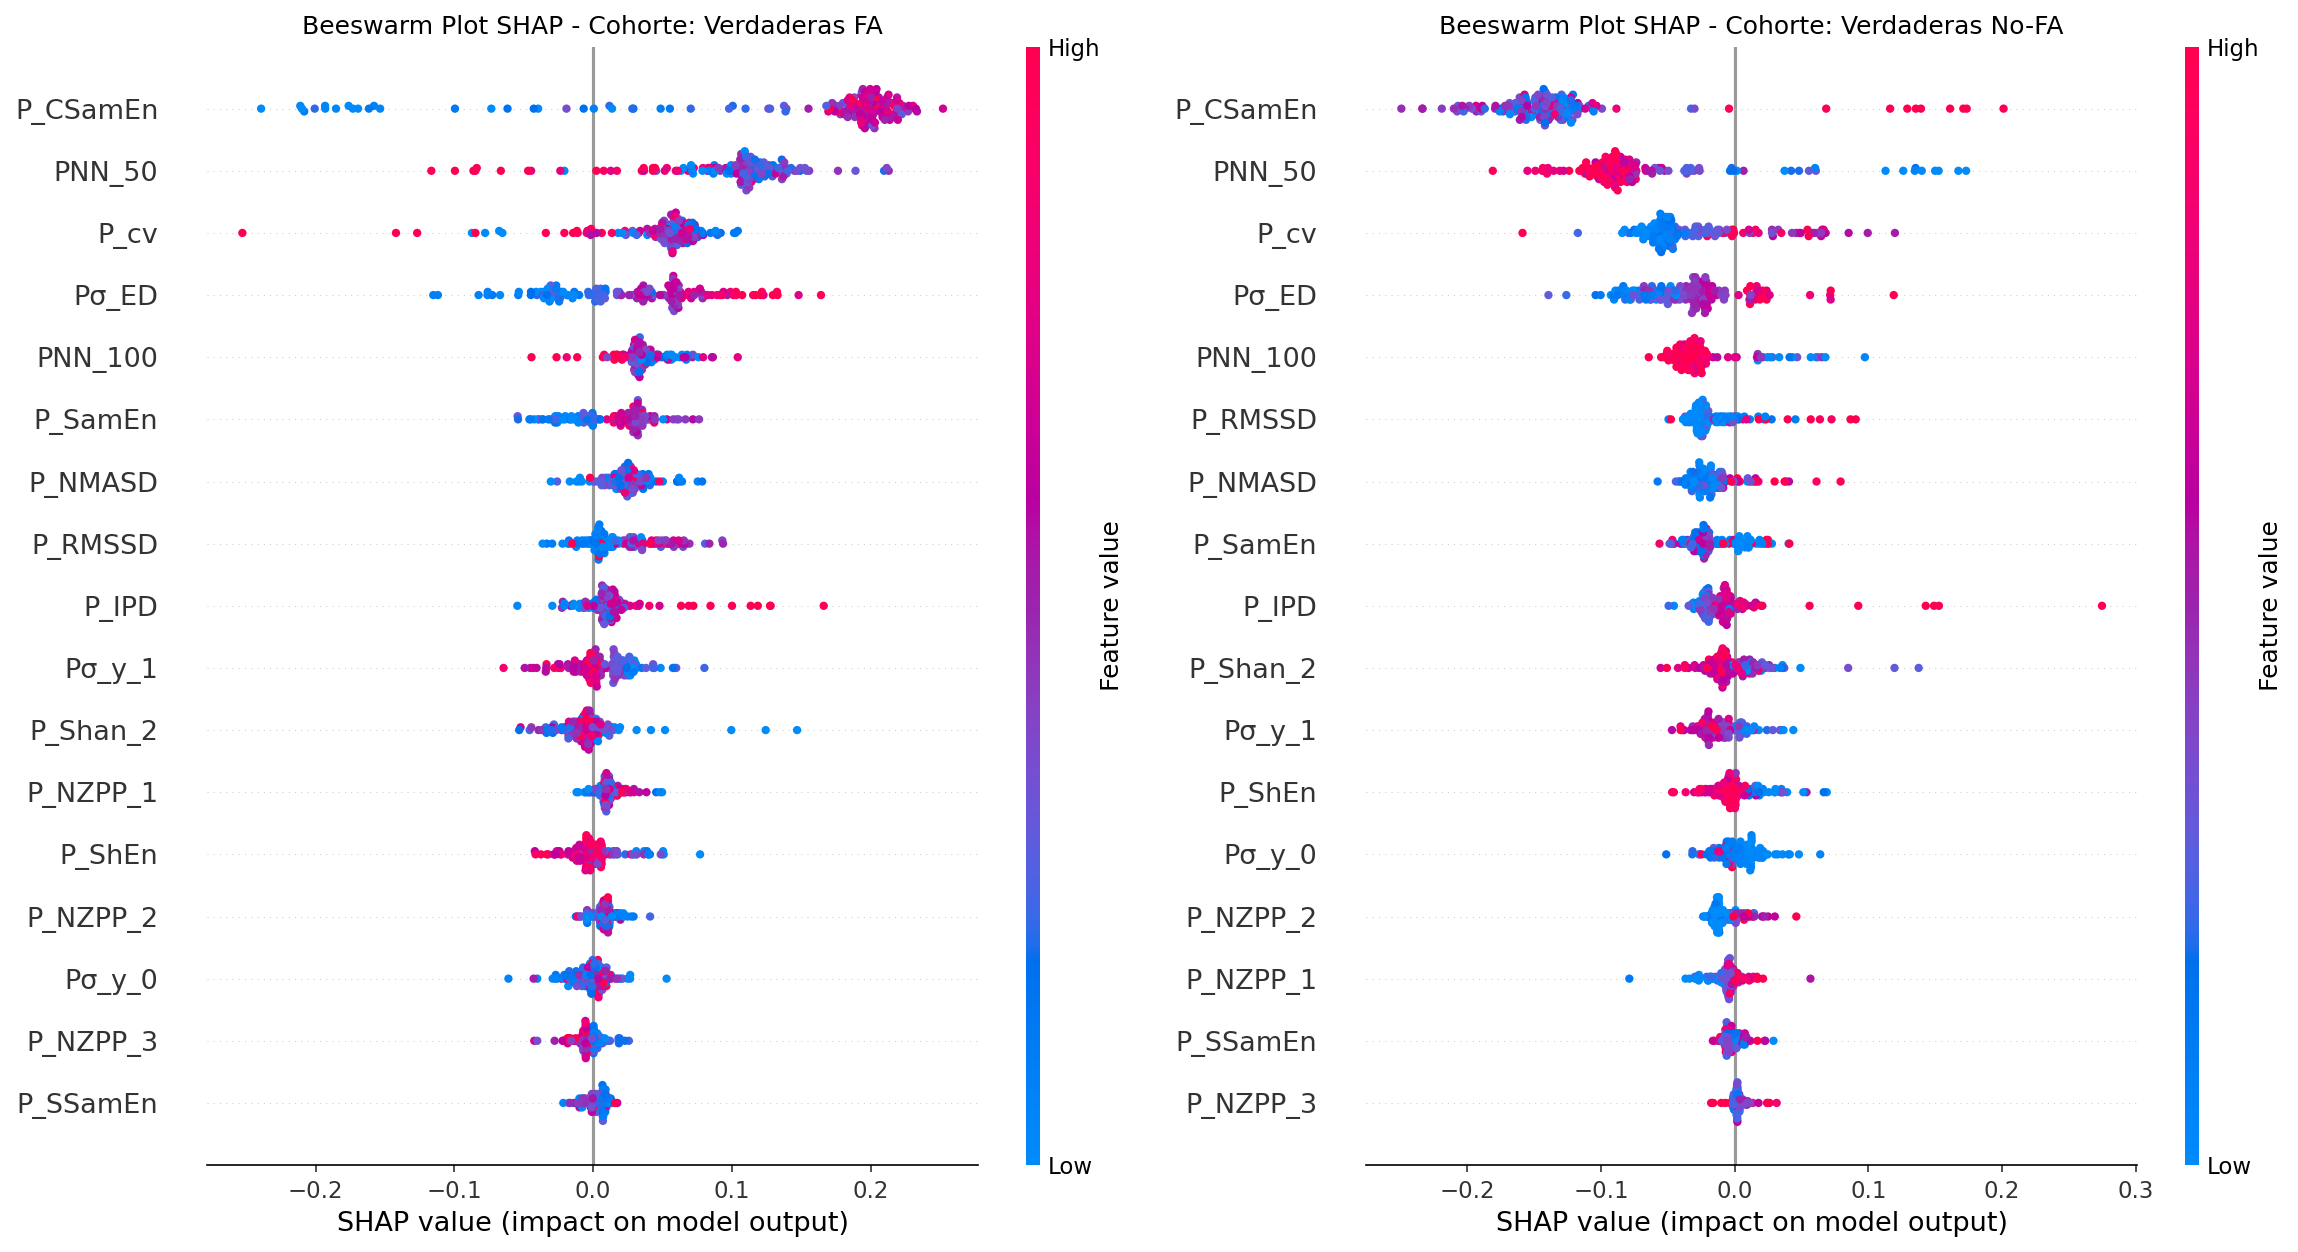

Imágenes temporales eliminadas.


In [14]:
# Beeswarm Plots de SHAP por Cohorte 2x1

# Asegurarse de que las variables necesarias estén definidas:
# shap_values_test, X_test_df_for_shap, feature_cols, y_test
if 'shap_values_test' not in locals() or \
   'X_test_df_for_shap' not in locals() or \
   'feature_cols' not in locals() or \
   'y_test' not in locals():
    print("Error: Alguna variable necesaria no está definida. Ejecuta las celdas anteriores (hasta la 7).")
elif 'OUTPUT_PATH' not in locals() or not os.path.exists(OUTPUT_PATH):
    print(f"Error: OUTPUT_PATH ('{locals().get('OUTPUT_PATH', 'No definido')}') no está definido o no existe.")
else:
    try:
        print(f"\n--- Análisis SHAP Global: Beeswarm Plots por Cohorte de Etiqueta Verdadera (Lado a Lado) ---")

        y_test_array = np.array(y_test)
        indices_fa_true = (y_test_array == 1)
        indices_nofa_true = (y_test_array == 0)

        path_beeswarm_fa = None
        path_beeswarm_nofa = None

        # --- Generar y Guardar Gráfico Beeswarm SHAP para VERDADERAS FA ---
        if np.sum(indices_fa_true) > 0:
            shap_values_fa_true = shap_values_test[indices_fa_true, :]
            X_test_fa_true = X_test_df_for_shap[indices_fa_true]

            print(f"\nGenerando Gráfico Beeswarm SHAP para VERDADERAS FA ({np.sum(indices_fa_true)} muestras)...")
            plt.figure() # Crear una nueva figura
            shap.summary_plot(shap_values_fa_true, X_test_fa_true, plot_type="dot", feature_names=feature_cols, show=False)
            plt.title(f"Beeswarm Plot SHAP - Cohorte: Verdaderas FA")
            path_beeswarm_fa = os.path.join(OUTPUT_PATH, 'SHAP_beeswarm_cohorte_FA_true_temp.png')
            plt.savefig(path_beeswarm_fa, dpi=150, bbox_inches='tight') # Usar dpi más bajo para temp si se desea
            print(f"Beeswarm plot temporal para Verdaderas FA guardado en: {path_beeswarm_fa}")
            plt.close() # Cerrar la figura para liberar memoria
        else:
            print("\nAdvertencia: No hay muestras de Verdaderas FA en el conjunto de prueba.")

        # --- Generar y Guardar Gráfico Beeswarm SHAP para VERDADERAS No-FA ---
        if np.sum(indices_nofa_true) > 0:
            shap_values_nofa_true = shap_values_test[indices_nofa_true, :]
            X_test_nofa_true = X_test_df_for_shap[indices_nofa_true]

            print(f"\nGenerando Gráfico Beeswarm SHAP para VERDADERAS No-FA ({np.sum(indices_nofa_true)} muestras)...")
            plt.figure() # Crear una nueva figura
            shap.summary_plot(shap_values_nofa_true, X_test_nofa_true, plot_type="dot", feature_names=feature_cols, show=False)
            plt.title(f"Beeswarm Plot SHAP - Cohorte: Verdaderas No-FA")
            path_beeswarm_nofa = os.path.join(OUTPUT_PATH, 'SHAP_beeswarm_cohorte_NoFA_true_temp.png')
            plt.savefig(path_beeswarm_nofa, dpi=150, bbox_inches='tight')
            print(f"Beeswarm plot temporal para Verdaderas No-FA guardado en: {path_beeswarm_nofa}")
            plt.close() # Cerrar la figura
        else:
            print("\nAdvertencia: No hay muestras de Verdaderas No-FA en el conjunto de prueba.")

        # --- Combinar las imágenes guardadas lado a lado ---
        if path_beeswarm_fa and path_beeswarm_nofa:
            img_fa = Image.open(path_beeswarm_fa)
            img_nofa = Image.open(path_beeswarm_nofa)

            # Asegurar que ambas imágenes tengan la misma altura para la combinación horizontal
            height = max(img_fa.height, img_nofa.height)
            img_fa = img_fa.resize((int(img_fa.width * height / img_fa.height), height))
            img_nofa = img_nofa.resize((int(img_nofa.width * height / img_nofa.height), height))

            total_width = img_fa.width + img_nofa.width + 20 # 20px de espacio
            combined_image = Image.new('RGB', (total_width, height), color=(255,255,255))
            combined_image.paste(img_fa, (0, 0))
            combined_image.paste(img_nofa, (img_fa.width + 20, 0))

            combined_beeswarm_filename = os.path.join(OUTPUT_PATH, 'SHAP_beeswarm_cohortes_combinado.png')
            combined_image.save(combined_beeswarm_filename)
            print(f"\nBeeswarm plots combinados guardados en: {combined_beeswarm_filename}")

            # Mostrar la imagen combinada en el notebook
            from IPython.display import Image as IPImage, display
            display(IPImage(filename=combined_beeswarm_filename))

            # Eliminar imágenes temporales
            os.remove(path_beeswarm_fa)
            os.remove(path_beeswarm_nofa)
            print("Imágenes temporales eliminadas.")

        elif path_beeswarm_fa: # Solo se generó el de FA
            print("Solo se generó el beeswarm plot para Verdaderas FA. Mostrando ese.")
            from IPython.display import Image as IPImage, display
            display(IPImage(filename=path_beeswarm_fa))
            os.rename(path_beeswarm_fa, os.path.join(OUTPUT_PATH, 'SHAP_beeswarm_cohorte_FA_true.png'))


        elif path_beeswarm_nofa: # Solo se generó el de No-FA
            print("Solo se generó el beeswarm plot para Verdaderas No-FA. Mostrando ese.")
            from IPython.display import Image as IPImage, display
            display(IPImage(filename=path_beeswarm_nofa))
            os.rename(path_beeswarm_nofa, os.path.join(OUTPUT_PATH, 'SHAP_beeswarm_cohorte_NoFA_true.png'))
        else:
            print("\nNo se generaron imágenes para combinar.")

    except Exception as e:
        print(f"Un error CRÍTICO inesperado ocurrió al generar los beeswarm plots por cohorte combinados: {e}")
        import traceback
        traceback.print_exc()


--- Análisis SHAP Global: Tres Beeswarm Plots Lado a Lado ---

Generando Gráfico Beeswarm SHAP GLOBAL (300 muestras)...
Beeswarm plot Global guardado temporalmente en: /content/drive/MyDrive/Doctorado/XAI/Final_XAI_FA/SHAP_beeswarm_GLOBAL_temp.png

Generando Gráfico Beeswarm SHAP para VERDADERAS FA (150 muestras)...
Beeswarm plot temporal para Verdaderas FA guardado en: /content/drive/MyDrive/Doctorado/XAI/Final_XAI_FA/SHAP_beeswarm_cohorte_FA_true_temp.png

Generando Gráfico Beeswarm SHAP para VERDADERAS No-FA (150 muestras)...
Beeswarm plot temporal para Verdaderas No-FA guardado en: /content/drive/MyDrive/Doctorado/XAI/Final_XAI_FA/SHAP_beeswarm_cohorte_NoFA_true_temp.png

Beeswarm plots (Global, FA, No-FA) combinados guardados en: /content/drive/MyDrive/Doctorado/XAI/Final_XAI_FA/SHAP_beeswarm_Global_FA_NoFA_combinado.png


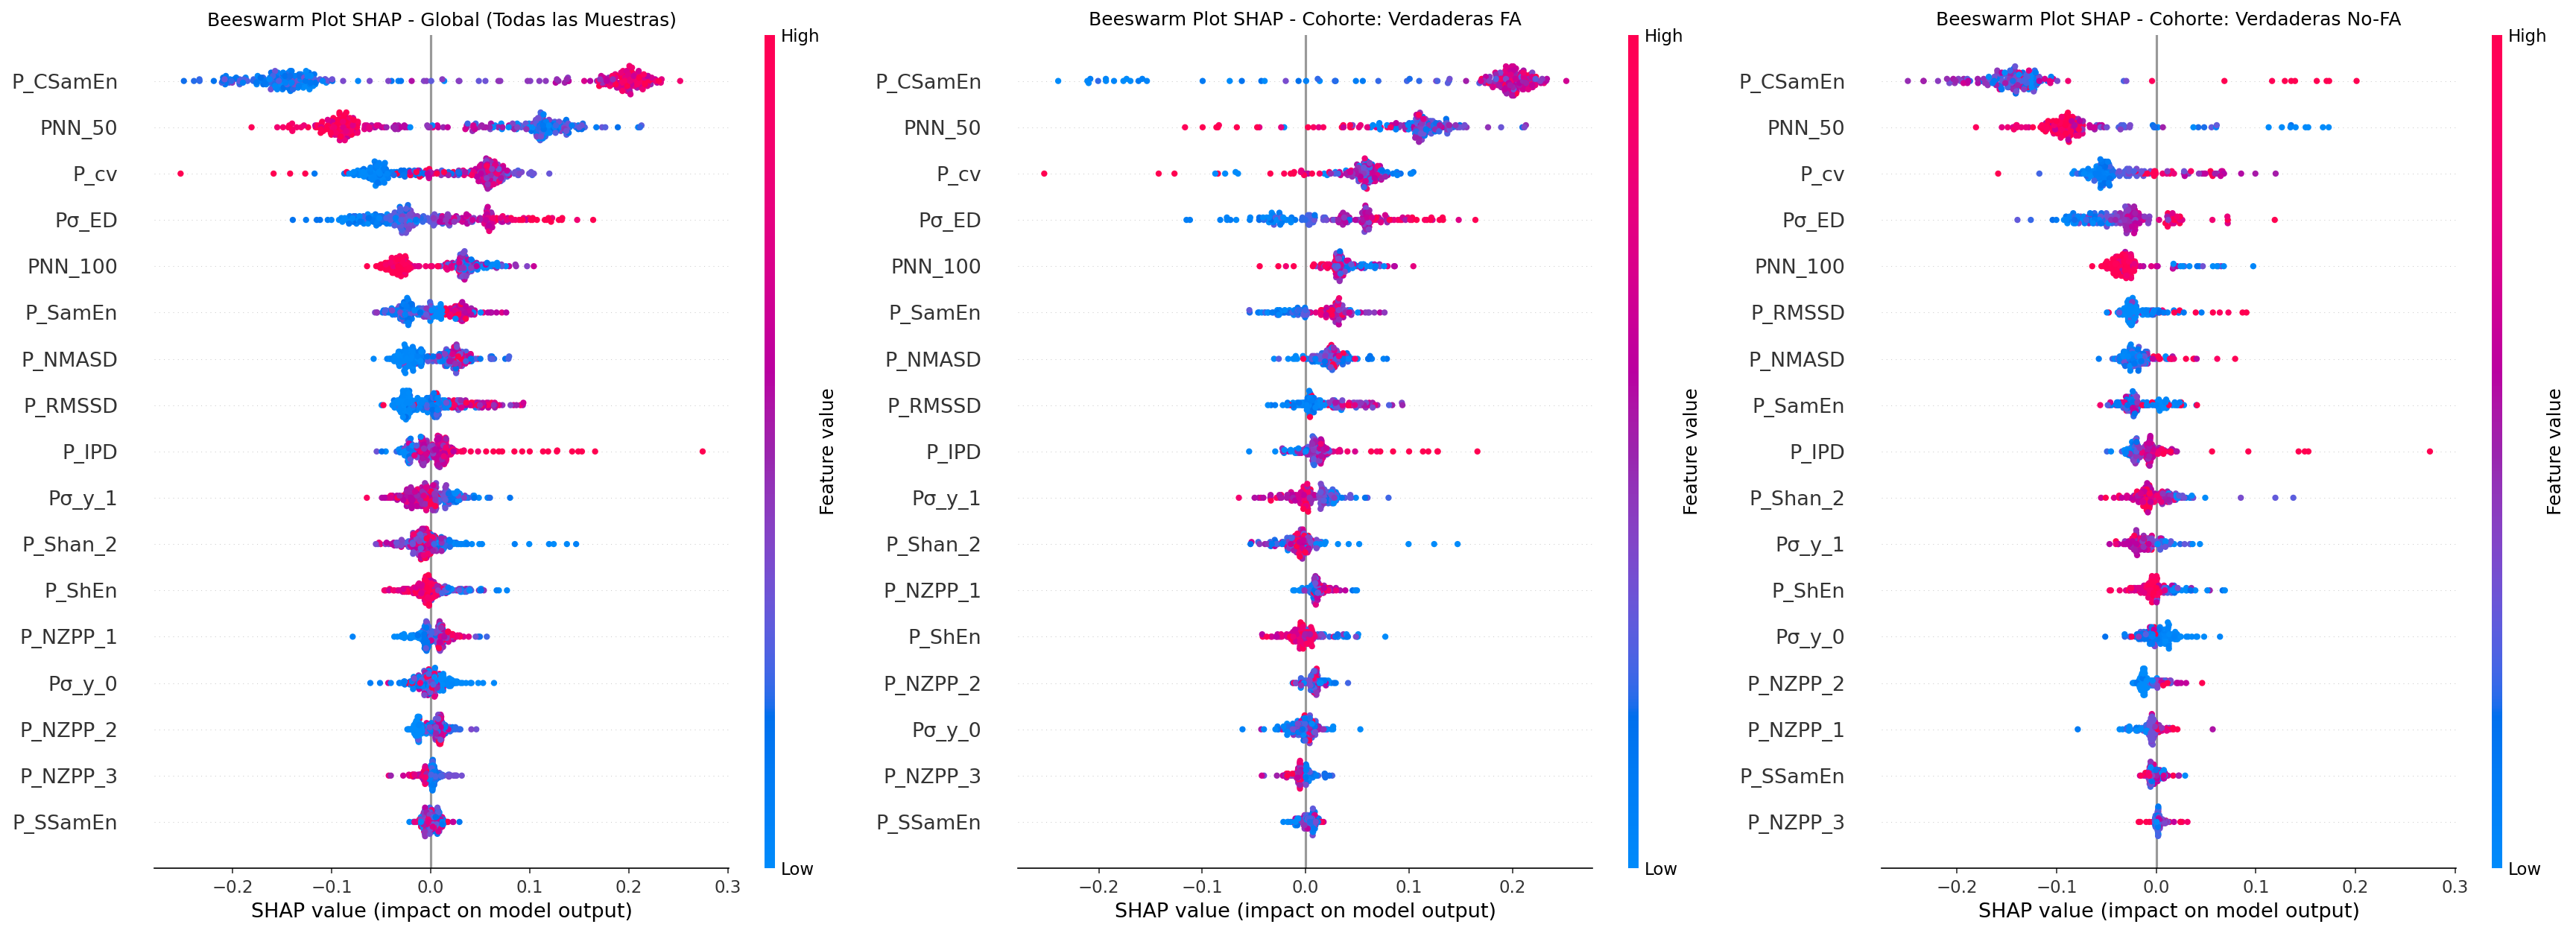

Imágenes temporales eliminadas.


In [15]:
# Tres Beeswarm Plots de SHAP (Global, FA Verdadera, No-FA Verdadera)

# Asegurarse de que las variables necesarias estén definidas:
# shap_values_test, X_test_df_for_shap, feature_cols, y_test
if 'shap_values_test' not in locals() or \
   'X_test_df_for_shap' not in locals() or \
   'feature_cols' not in locals() or \
   'y_test' not in locals():
    print("Error: Alguna variable necesaria no está definida. Ejecuta las celdas anteriores (hasta la 7).")
elif 'OUTPUT_PATH' not in locals() or not os.path.exists(OUTPUT_PATH):
    print(f"Error: OUTPUT_PATH ('{locals().get('OUTPUT_PATH', 'No definido')}') no está definido o no existe.")
else:
    try:
        print(f"\n--- Análisis SHAP Global: Tres Beeswarm Plots Lado a Lado ---")

        y_test_array = np.array(y_test)
        indices_fa_true = (y_test_array == 1)
        indices_nofa_true = (y_test_array == 0)

        path_beeswarm_global = None
        path_beeswarm_fa = None
        path_beeswarm_nofa = None

        # --- 1. Generar y Guardar Gráfico Beeswarm SHAP GLOBAL ---
        print(f"\nGenerando Gráfico Beeswarm SHAP GLOBAL ({shap_values_test.shape[0]} muestras)...")
        plt.figure()
        shap.summary_plot(shap_values_test, X_test_df_for_shap, plot_type="dot", feature_names=feature_cols, show=False)
        plt.title(f"Beeswarm Plot SHAP - Global (Todas las Muestras)")
        path_beeswarm_global = os.path.join(OUTPUT_PATH, 'SHAP_beeswarm_GLOBAL_temp.png')
        plt.savefig(path_beeswarm_global, dpi=150, bbox_inches='tight')
        print(f"Beeswarm plot Global guardado temporalmente en: {path_beeswarm_global}")
        plt.close()

        # --- 2. Generar y Guardar Gráfico Beeswarm SHAP para VERDADERAS FA ---
        if np.sum(indices_fa_true) > 0:
            shap_values_fa_true = shap_values_test[indices_fa_true, :]
            X_test_fa_true = X_test_df_for_shap[indices_fa_true]
            print(f"\nGenerando Gráfico Beeswarm SHAP para VERDADERAS FA ({np.sum(indices_fa_true)} muestras)...")
            plt.figure()
            shap.summary_plot(shap_values_fa_true, X_test_fa_true, plot_type="dot", feature_names=feature_cols, show=False)
            plt.title(f"Beeswarm Plot SHAP - Cohorte: Verdaderas FA")
            path_beeswarm_fa = os.path.join(OUTPUT_PATH, 'SHAP_beeswarm_cohorte_FA_true_temp.png')
            plt.savefig(path_beeswarm_fa, dpi=150, bbox_inches='tight')
            print(f"Beeswarm plot temporal para Verdaderas FA guardado en: {path_beeswarm_fa}")
            plt.close()
        else:
            print("\nAdvertencia: No hay muestras de Verdaderas FA en el conjunto de prueba.")

        # --- 3. Generar y Guardar Gráfico Beeswarm SHAP para VERDADERAS No-FA ---
        if np.sum(indices_nofa_true) > 0:
            shap_values_nofa_true = shap_values_test[indices_nofa_true, :]
            X_test_nofa_true = X_test_df_for_shap[indices_nofa_true]
            print(f"\nGenerando Gráfico Beeswarm SHAP para VERDADERAS No-FA ({np.sum(indices_nofa_true)} muestras)...")
            plt.figure()
            shap.summary_plot(shap_values_nofa_true, X_test_nofa_true, plot_type="dot", feature_names=feature_cols, show=False)
            plt.title(f"Beeswarm Plot SHAP - Cohorte: Verdaderas No-FA")
            path_beeswarm_nofa = os.path.join(OUTPUT_PATH, 'SHAP_beeswarm_cohorte_NoFA_true_temp.png')
            plt.savefig(path_beeswarm_nofa, dpi=150, bbox_inches='tight')
            print(f"Beeswarm plot temporal para Verdaderas No-FA guardado en: {path_beeswarm_nofa}")
            plt.close()
        else:
            print("\nAdvertencia: No hay muestras de Verdaderas No-FA en el conjunto de prueba.")

        # --- 4. Combinar las tres imágenes guardadas lado a lado ---
        images_to_combine = []
        if path_beeswarm_global:
            images_to_combine.append(Image.open(path_beeswarm_global))
        if path_beeswarm_fa:
            images_to_combine.append(Image.open(path_beeswarm_fa))
        if path_beeswarm_nofa:
            images_to_combine.append(Image.open(path_beeswarm_nofa))

        if len(images_to_combine) > 0:
            # Asegurar que todas las imágenes tengan la misma altura para la combinación horizontal
            # Tomar la altura de la imagen más alta como referencia
            max_height = 0
            for img in images_to_combine:
                if img.height > max_height:
                    max_height = img.height

            # Redimensionar todas las imágenes a la misma altura, manteniendo la relación de aspecto
            resized_images = []
            for img in images_to_combine:
                if img.height == max_height:
                    resized_images.append(img)
                else:
                    aspect_ratio = img.width / img.height
                    new_width = int(aspect_ratio * max_height)
                    resized_images.append(img.resize((new_width, max_height)))

            # Calcular el ancho total para la imagen combinada
            spacing = 20 # Espacio en píxeles entre imágenes
            total_width_combined = sum(img.width for img in resized_images) + spacing * (len(resized_images) - 1)

            combined_image = Image.new('RGB', (total_width_combined, max_height), color=(255,255,255))

            current_x_offset = 0
            for img in resized_images:
                combined_image.paste(img, (current_x_offset, 0))
                current_x_offset += img.width + spacing

            final_combined_filename = os.path.join(OUTPUT_PATH, 'SHAP_beeswarm_Global_FA_NoFA_combinado.png')
            combined_image.save(final_combined_filename)
            print(f"\nBeeswarm plots (Global, FA, No-FA) combinados guardados en: {final_combined_filename}")

            display(IPImage(filename=final_combined_filename))

            # Eliminar imágenes temporales
            if path_beeswarm_global: os.remove(path_beeswarm_global)
            if path_beeswarm_fa: os.remove(path_beeswarm_fa)
            if path_beeswarm_nofa: os.remove(path_beeswarm_nofa)
            print("Imágenes temporales eliminadas.")
        else:
            print("\nNo se generaron suficientes imágenes individuales para combinar.")

    except Exception as e:
        print(f"Un error CRÍTICO inesperado ocurrió al generar los beeswarm plots por cohorte combinados: {e}")
        import traceback
        traceback.print_exc()


--- Generando Barplot SHAP Agrupado por Cohorte de Etiqueta Verdadera (usando shap.Explanation) ---
Valor base para Explanation: 0.4499
Objeto shap.Explanation creado.
Cohortes definidas: {np.str_('FA Verdadera'): np.int64(150), np.str_('No-FA Verdadera'): np.int64(150)}

--- Generando Gráfico de Barras SHAP Agrupado por Cohorte de Etiqueta Verdadera ---
Gráfico con cohortes guardado en: /content/drive/MyDrive/Doctorado/XAI/Final_XAI_FA/SHAP_cohort_barplot_shap_style.png


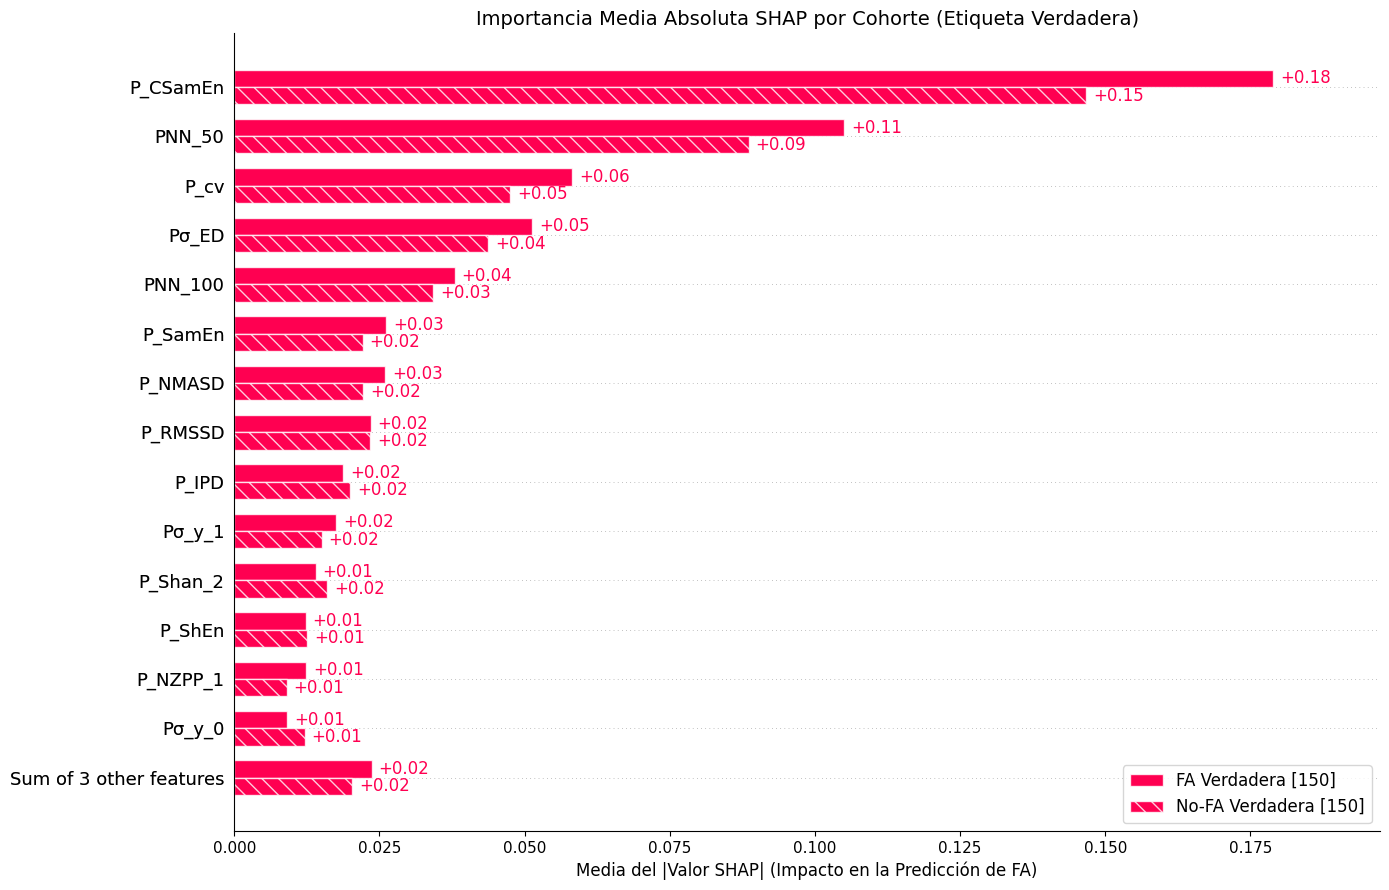

In [16]:
# Barplot SHAP con Cohortes (Método shap.Explanation) - Formato de 3 Decimales (Intento Mejorado)

# Asegurarse de que las variables necesarias estén definidas:
if 'shap_values_test' not in locals() or \
   'X_test_df_for_shap' not in locals() or \
   'feature_cols' not in locals() or \
   'y_test' not in locals() or \
   'explainer' not in locals():
    print("Error: Alguna variable necesaria no está definida. Asegúrate de haber ejecutado las celdas anteriores.")
else:
    try:
        print(f"\n--- Generando Barplot SHAP Agrupado por Cohorte de Etiqueta Verdadera (usando shap.Explanation) ---")

        # 1. Determinar el valor base apropiado para el objeto Explanation
        base_value_for_explanation = explainer.expected_value
        if isinstance(base_value_for_explanation, (list, np.ndarray)):
            if len(base_value_for_explanation) == 2:
                base_value_for_explanation = base_value_for_explanation[1]
            elif len(base_value_for_explanation) == 1:
                base_value_for_explanation = base_value_for_explanation[0]
        print(f"Valor base para Explanation: {base_value_for_explanation:.4f}")

        # 2. Crear el array de valores base
        base_values_array = np.full(shap_values_test.shape[0], base_value_for_explanation)

        # 3. Crear el objeto shap.Explanation
        explanation_object = shap.Explanation(
            values=shap_values_test,
            base_values=base_values_array,
            data=X_test_df_for_shap.values,
            feature_names=feature_cols
        )
        print("Objeto shap.Explanation creado.")

        # 4. Crear el array de cohortes
        y_test_array = np.array(y_test)
        y_test_labels_for_cohorts = ["FA Verdadera" if label == 1 else "No-FA Verdadera" for label in y_test_array]

        if len(y_test_labels_for_cohorts) != explanation_object.shape[0]:
            raise ValueError("La longitud de y_test_labels_for_cohorts no coincide con los datos SHAP.")

        unique_cohorts, cohort_counts = np.unique(y_test_labels_for_cohorts, return_counts=True)
        print(f"Cohortes definidas: {dict(zip(unique_cohorts, cohort_counts))}")
        sorted_cohort_names = sorted(unique_cohorts.tolist())


        # 5. Aplicar cohortes y generar el bar plot
        print("\n--- Generando Gráfico de Barras SHAP Agrupado por Cohorte de Etiqueta Verdadera ---")

        # Colores personalizados
        color_fa_rgb_normalized = (255/255, 0/255, 81/255)
        color_nofa_rgb_normalized = (0/255, 139/255, 251/255)

        if sorted_cohort_names[0] == "FA Verdadera":
             cohort_colors_ordered = [color_fa_rgb_normalized, color_nofa_rgb_normalized]
        else:
             cohort_colors_ordered = [color_nofa_rgb_normalized, color_fa_rgb_normalized]

        # Crear la figura y los ejes explícitamente
        fig, ax = plt.subplots(figsize=(14, 9)) # Aumenté un poco el alto para dar espacio

        # Llamar a shap.plots.bar pasándole el eje
        shap.plots.bar(explanation_object.cohorts(y_test_labels_for_cohorts).abs.mean(0),
                       show=False, # Importante: no mostrar inmediatamente
                       max_display=15,
                       ax=ax) # Dibujar en nuestros ejes

        # --- MODIFICACIONES DESPUÉS DE QUE SHAP DIBUJE ---

        # # 1. Ajustar colores (si es necesario y si SHAP no usó un argumento de color de cohorte)
        # bars_collections = ax.containers
        # if len(bars_collections) == len(cohort_colors_ordered):
        #     # Reconfirmar el orden de la leyenda generada por SHAP
        #     legend_handles, legend_texts = ax.get_legend_handles_labels()
        #     current_legend_order = [text for text in legend_texts] # Nombres de las cohortes en la leyenda

        #     # Crear un mapeo de nombre de cohorte a color deseado
        #     color_map_desired = {}
        #     if "FA Verdadera" in current_legend_order:
        #         color_map_desired["FA Verdadera"] = color_fa_rgb_normalized
        #     if "No-FA Verdadera" in current_legend_order:
        #         color_map_desired["No-FA Verdadera"] = color_nofa_rgb_normalized

        #     for i, bar_collection in enumerate(bars_collections):
        #         # Usar el nombre de la cohorte de la leyenda para obtener el color correcto
        #         # Esto es más robusto que asumir un orden fijo.
        #         if i < len(current_legend_order) and current_legend_order[i] in color_map_desired:
        #             for bar in bar_collection:
        #                 bar.set_color(color_map_desired[current_legend_order[i]])
        #         else:
        #             print(f"Advertencia: No se pudo asignar color a la colección de barras {i} por falta de coincidencia en leyenda.")
        # else:
        #     print(f"Advertencia: No se pudo aplicar colores personalizados. Número de colecciones de barras ({len(bars_collections)}) no coincide con número de cohortes ({len(cohort_colors_ordered)}).")

        # 2. Establecer el título y etiquetas de los ejes
        ax.set_title("Importancia Media Absoluta SHAP por Cohorte (Etiqueta Verdadera)", fontsize=14)
        # El xlabel usualmente lo pone bien SHAP, pero puedes forzarlo:
        ax.set_xlabel("Media del |Valor SHAP| (Impacto en la Predicción de FA)", fontsize=12)
        # El ylabel (features) también lo maneja SHAP.

        # 3. Ajustar layout y mostrar/guardar
        plt.tight_layout()

        plot_filename_cohorts_shap_style = os.path.join(OUTPUT_PATH, 'SHAP_cohort_barplot_shap_style.png')
        plt.savefig(plot_filename_cohorts_shap_style, dpi=300, bbox_inches='tight')
        print(f"Gráfico con cohortes guardado en: {plot_filename_cohorts_shap_style}")
        plt.show()

    except Exception as e:
        print(f"Un error CRÍTICO inesperado ocurrió en la Celda: {e}")
        traceback.print_exc()


--- Generando Barplot Manual de Importancia SHAP por Cohorte de Etiqueta Verdadera (colores RGB personalizados) ---
Número de muestras en cohorte FA Verdadera: 150
Número de muestras en cohorte No-FA Verdadera: 150

--- Top Features por Importancia Media Absoluta SHAP en Cohortes ---
          FA Verdadera  No-FA Verdadera
feature                                
P_CSamEn      0.178959         0.146735
PNN_50        0.105069         0.088586
P_cv          0.058178         0.047478
Pσ_ED         0.051353         0.043755
PNN_100       0.037956         0.034198
P_SamEn       0.026131         0.022105
P_NMASD       0.026011         0.022212
P_RMSSD       0.023471         0.023430
P_IPD         0.018727         0.019967
Pσ_y_1        0.017537         0.015031
P_Shan_2      0.013997         0.016039
P_ShEn        0.012278         0.012532
P_NZPP_1      0.012429         0.009046
Pσ_y_0        0.009172         0.012147
P_NZPP_2      0.009423         0.011222

Cohort Bar Plot manual (colores R

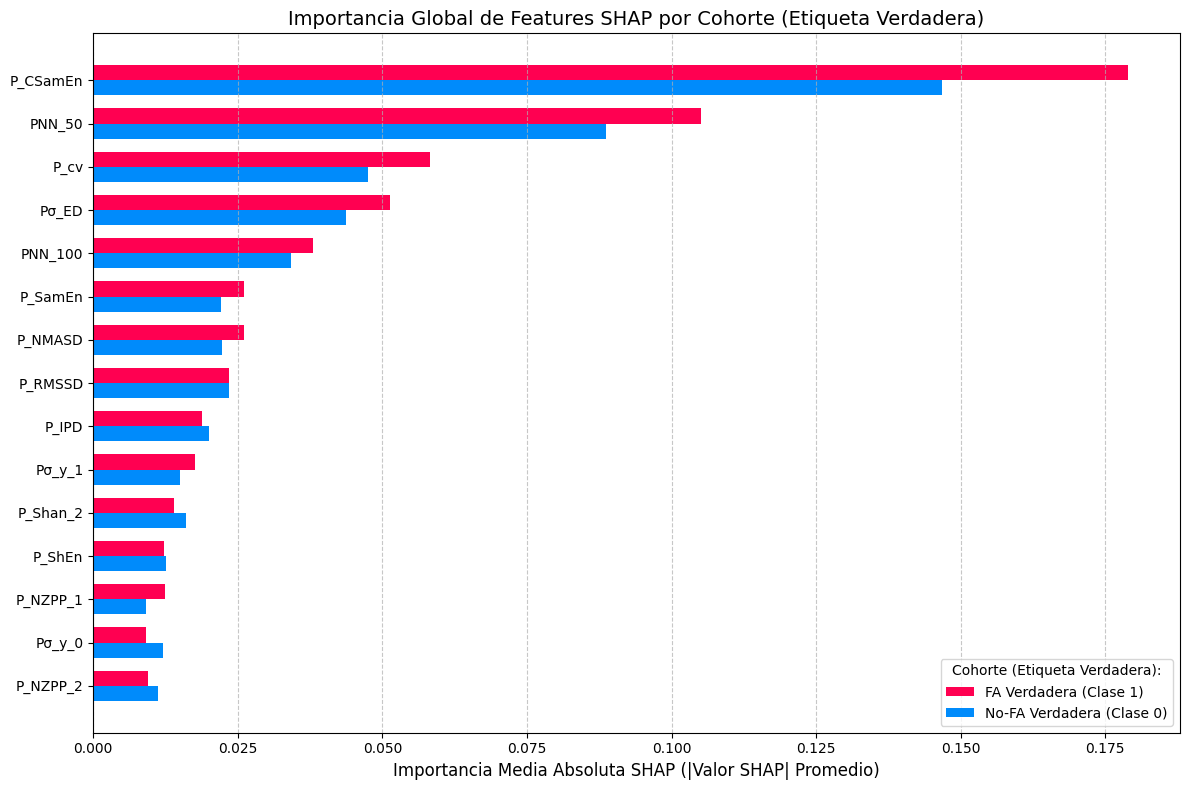

In [17]:
# Barplot Manual de Importancia Media Absoluta SHAP por Cohorte de Etiqueta Verdadera (con colores RGB personalizados)

# Asegurarse de que las variables necesarias estén definida
if 'shap_values_test' not in locals() or \
   'X_test_df_for_shap' not in locals() or \
   'feature_cols' not in locals() or \
   'y_test' not in locals():
    print("Error: Alguna variable necesaria no está definida. Ejecuta celdas anteriores.")
else:
    try:
        print(f"\n--- Generando Barplot Manual de Importancia SHAP por Cohorte de Etiqueta Verdadera (colores RGB personalizados) ---")

        # 1. Extraer clases (asegurarse de que y_test sea un array NumPy para indexación booleana)
        y_values = np.array(y_test)

        # Filtrar shap_values_test para cada cohorte
        shap_fa_true = shap_values_test[y_values == 1]
        shap_nofa_true = shap_values_test[y_values == 0]

        print(f"Número de muestras en cohorte FA Verdadera: {shap_fa_true.shape[0]}")
        print(f"Número de muestras en cohorte No-FA Verdadera: {shap_nofa_true.shape[0]}")

        # 2. Calcular media de |SHAP| por grupo (cohorte)
        mean_abs_shap_fa = np.zeros(len(feature_cols))
        if shap_fa_true.shape[0] > 0:
            mean_abs_shap_fa = np.abs(shap_fa_true).mean(axis=0)

        mean_abs_shap_nofa = np.zeros(len(feature_cols))
        if shap_nofa_true.shape[0] > 0:
            mean_abs_shap_nofa = np.abs(shap_nofa_true).mean(axis=0)

        # 3. Crear DataFrame para graficar
        df_cohort_shap = pd.DataFrame({
            'feature': feature_cols,
            'FA Verdadera': mean_abs_shap_fa,
            'No-FA Verdadera': mean_abs_shap_nofa
        }).set_index('feature')

        # 4. Seleccionar top N features por importancia total
        df_cohort_shap['total_importance'] = df_cohort_shap['FA Verdadera'] + df_cohort_shap['No-FA Verdadera']
        # Ordenar primero por total_importance, y luego alfabéticamente para desempates y consistencia si es necesario
        df_top_cohort = df_cohort_shap.sort_values(by=['total_importance', 'feature'], ascending=[False, True]).head(15)
        df_top_cohort = df_top_cohort.drop(columns='total_importance')

        print("\n--- Top Features por Importancia Media Absoluta SHAP en Cohortes ---")
        print(df_top_cohort)

        # 5. Graficar (barras horizontales agrupadas)

        # Definir tus colores RGB personalizados y normalizarlos (dividir por 255)
        color_fa_rgb_normalized = (255/255, 0/255, 81/255)     # rgb(255,0,81)
        color_nofa_rgb_normalized = (0/255, 139/255, 251/255)  # rgb(0,139,251)

        fig, ax = plt.subplots(figsize=(12, 8))
        bar_width = 0.35
        indices = np.arange(len(df_top_cohort))

        # Barras para FA Verdadera
        ax.barh(indices - bar_width/2, df_top_cohort['FA Verdadera'], bar_width, label='FA Verdadera (Clase 1)', color=color_fa_rgb_normalized)
        # Barras para No-FA Verdadera
        ax.barh(indices + bar_width/2, df_top_cohort['No-FA Verdadera'], bar_width, label='No-FA Verdadera (Clase 0)', color=color_nofa_rgb_normalized)

        ax.set_yticks(indices)
        ax.set_yticklabels(df_top_cohort.index)
        ax.invert_yaxis()
        ax.set_xlabel('Importancia Media Absoluta SHAP (|Valor SHAP| Promedio)', fontsize=12)
        ax.set_title('Importancia Global de Features SHAP por Cohorte (Etiqueta Verdadera)', fontsize=14)
        ax.legend(title="Cohorte (Etiqueta Verdadera):")
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()

        # Guardar y mostrar
        cohort_plot_path_custom_rgb = os.path.join(OUTPUT_PATH, 'SHAP_cohort_barplot.png')
        try:
            fig.savefig(cohort_plot_path_custom_rgb, dpi=300, bbox_inches='tight')
            print(f"\nCohort Bar Plot manual (colores RGB personalizados) guardado en: {cohort_plot_path_custom_rgb}")
        except Exception as e_save:
            print(f"Error al guardar el gráfico de cohorte: {e_save}")

        plt.show()

    except Exception as e:
        print(f"Un error CRÍTICO inesperado ocurrió en la Celda: {e}")
        traceback.print_exc()

## Beeswarm Plot

Este grafico da una visión general de la importancia de las features y cómo afectan las predicciones del modelo en todo un conjunto de datos.

1. **Eje Y (Vertical): Features**

Las features están ordenadas verticalmente por su importancia global. La feature en la parte superior es la que tiene el mayor impacto promedio (en magnitud) en las predicciones del modelo a lo largo de todas las muestras del conjunto de prueba. La importancia global se calcula como el valor absoluto medio de los valores SHAP para esa feature en todas las muestras.

2. **Eje X (Horizontal): Valor SHAP (Impacto en la Salida del Modelo)**

Este eje muestra el valor SHAP calculado para cada feature en cada instancia.

* El punto central (Valor SHAP = 0) representa la línea base; features con puntos aquí tuvieron poco o ningún impacto en esa predicción específica en relación con la predicción promedio.
* Valores SHAP > 0: Empujan la predicción hacia una mayor probabilidad de FA.
* Valores SHAP < 0: Empujan la predicción hacia una menor probabilidad de FA (es decir, mayor probabilidad de No-FA).

3. **Puntos (El "Enjambre"): Instancias Individuales**

Cada punto en el gráfico representa una observación (una fila) del conjunto de datos. La posición horizontal de un punto en la fila de una feature específica te dice el valor SHAP de esa feature para esa instancia.
Los puntos se "apilan" verticalmente cuando tienen valores SHAP similares para mostrar la densidad o distribución. Esto es lo que le da la apariencia de "enjambre de abejas".


4. **Color de los Puntos: Valor de la Feature**

El color de cada punto indica el valor original (en este caso, escalado, ya que usmaos un scaler) de la feature para esa instancia.

SHAP generalmente usa una escala de colores donde Rojo representa valores altos de la feature, mientras que Azul representa valores bajos de la feature.

---

### Features más importantes

1. **`P_CSamEn`** (Feature más importante):

Los puntos rojos (valores altos) tienden a estar a la derecha del gráfico (valores SHAP positivos). Los puntos azules (valores bajos) tienden a estar a la izquierda (valores SHAP negativos).

Valores altos de P_CSamEn aumentan la probabilidad de FA, y valores bajos disminuyen la probabilidad de FA (aumentan la de No-FA). Esto es consistente con que en FA tiende a ser mayor. La dispersión de los puntos a lo largo del eje X para esta feature es amplia, indicando su fuerte impacto.

2. **`PNN_50`** (Segunda feature más importante):

Los puntos azules (valores bajos) tienden a estar a la derecha (valores SHAP positivos), empujando hacia FA. Los puntos rojos (valores altos) tienden a estar a la izquierda (valores SHAP negativos), empujando hacia No-FA.

Valores bajos de PNN_50 aumentan la probabilidad de FA, y valores altos disminuyen la probabilidad de FA. Esto se contradice a lo propuesto: "En FA tiende a ser mayor".

Esto puede indicar que: El modelo XGBoost ha encontrado una relación diferente en los datos (quizás debido a interacciones con otras features) a la esperada teóricamente o en estudios univariados. O que el balanceo de clases o el escalado podrían haber influido en cómo el modelo "ve" esta feature. O es una característica genuina del comportamiento de tu modelo entrenado.

3. **`P_cv`** (Tercera feature más importante):

Los puntos rojos (valores altos) tienden a estar a la derecha (SHAP positivos). Los puntos azules (valores bajos de P_cv) podrían mostrar una relación más mixta, pero la instancia 0 (valor bajo) empuja hacia FA, mientras que la instancia 3 (valor muy bajo) empuja hacia No-FA.

Generalmente, valores más altos de P_cv parecen aumentar la probabilidad de FA. Esto es consistente con que en FA tiende a ser mayor. La dispersión podría indicar que su efecto no es tan claro o monótono como el de P_CSamEn.

4. **`Pσ_ED`** (Cuarta feature más importante):

La relación también parece un poco compleja aquí. Valores bajos (azul) pueden empujar en ambas direcciones dependiendo de la instancia.




## Bar Plot

Este grafico nos resume la importancia de cada feature en todo el conjunto de datos promediando la magnitud de sus impactos. Específicamente, para cada feature, calcula el valor SHAP absoluto medio a lo largo de todas las muestras:

$$\text{Importancia de la feature}_j = \frac{1}{N} \sum_{i=1}^{N} |\text{SHAP_value}_{ij}|$$

donde $N$ es el número de muestras en tu conjunto de prueba, y $|\text{SHAP_value}_{ij}|$ es el valor absoluto del valor SHAP para la muestra i y la feature j.

---

### Features más importantes

* **`P_CSamEn`** (Coeficiente de Entropía de Muestreo) es, con diferencia, la feature más influyente del modelo. Su valor SHAP absoluto medio (0.163) es considerablemente más alto que el de la siguiente feature. Esto significa que, en promedio, el valor de **`P_CSamEn`** tiene el mayor poder para cambiar la predicción del modelo (ya sea hacia FA o No-FA).

* **`PNN_50`** (Porcentaje de intervalos NN sucesivos que difieren en más de 50 ms)es la segunda feature más importante (0.097), aunque con un impacto promedio notablemente menor que **`P_CSamEn`**.

* Luego sigue un grupo de features con importancias decrecientes: **`P_cv`** (0.053), **`Pσ_ED`** (0.048), **`PNN_100`** (0.036).

* Features como **`P_SamEn`**, **`P_NMASD`**, y **`P_RMSSD`** tienen un impacto similar y moderado (alrededor de 0.023-0.024).

* El resto de las features, incluyendo `P_IPD`, varias métricas de Poincaré (`Pσ_y_1`, `P_NZPP_1`, `Pσ_y_0`, `P_NZPP_2`, `P_NZPP_3`) y las entropías de Shannon (`P_Shan_2`, `P_ShEn`) y `P_SSamEn`, tienen un impacto promedio menor en las predicciones de tu modelo. `P_SSamEn` y `P_NZPP_3` son las menos influyentes.

### Comentarios sobre PNN_50 y `beeswarm plot`

El `beeswarm plot` (y otros gráficos globales de `summary_plot`) se generan utilizando TODAS las muestras de tu conjunto de prueba `X_test`. Este `X_test` es una mezcla de:

* Instancias que son verdaderamente FA (según la etiqueta original, y_test == 1).
* Instancias que son verdaderamente No-FA (según la etiqueta original, y_test == 0, que incluye 'N' y 'O').

**El gráfico no separa automáticamente por la etiqueta verdadera**. Simplemente muestra el impacto de cada feature en la predicción del modelo (que es la probabilidad de ser FA) para todas las muestras que se le proporcionan. La distribución de puntos rojos y azules a lo largo del eje de valor SHAP para `PNN_50` refleja cómo el modelo está usando `PNN_50` en todo ese espectro mixto de muestras.

Entonces, **¿Por qué `PNN_50` podría comportarse "al revés" en el `beeswarm plot`?**

Observando el `beeswarm plot` que, para `PNN_50`:
* Puntos rojos (valores altos de `PNN_50`) tienden a tener valores SHAP negativos (empujan la predicción hacia No-FA).
* Puntos azules (valores bajos de `PNN_50`) tienden a tener valores SHAP positivos (empujan la predicción hacia FA).

Esto significaría que el modelo XGBoost usado ha aprendido que, en el contexto de los datos y las otras features, valores más bajos de `PNN_50` son más indicativos de FA, y valores más altos son más indicativos de No-FA. Esta es una inversión de la expectativa teórica de que "`PNN_50` tiende a ser mayor en FA".

Ahora bien, el porque podria deberse a distintas razones:
* **Interacciones Multivariadas Complejas**: Al trabajar con un modelo multivariado, el impacto de una feature no se considera de forma aislada, sino en el contexto de todas las demás features.
  * Podría ser que un `PNN_50` alto sea un indicador de No-FA especialmente cuando otras features ya sugieren fuertemente No-FA (por ejemplo, un `P_CSamEn` muy bajo). O, un `PNN_50` bajo podría ser un fuerte indicador de FA solo en presencia de un `P_CSamEn` alto.
  * SHAP desglosa el impacto marginal de `PNN_50`, pero este impacto ya refleja cómo `PNN_50` "ajusta" la predicción dado el estado de las otras 16 features para una muestra particular.
* **Características del Dataset de Entrenamiento Específico**: El modelo aprende exclusivamente de los patrones presentes en los datos con los que fue entrenado. Si en este dataset (después de todas las etapas de preprocesamiento, incluyendo la limpieza de ruido y, crucialmente, la eliminación de ectópicos que genera los intervalos NN para calcular `PNN_50`), los casos de FA que el modelo pudo distinguir mejor consistentemente presentaban valores de `PNN_50` más bajos en comparación con los casos de No-FA, el modelo aprendería esta correlación observada.
  * Esto podría ser una característica genuina de la subpoblación de datos, un artefacto del proceso de selección de datos original, o un efecto no intencionado del preprocesamiento.
* **Impacto del Preprocesamiento (Especialmente la eliminación de ectópicos)**: `PNN_50` se calcula sobre los intervalos NN. Estos se obtienen después de aplicar un clasificador de ruido (KNN) y un clasificador de ectópicos (XGBoost). La eliminación de ectópicos es un paso transformador. Si este proceso, por ejemplo:
  * Fue muy eficaz eliminando la mayoría de los latidos prematuros en los segmentos de FA, podría haber "regularizado" o "suavizado" la serie NN resultante de tal manera que el `PNN_50` calculado sea artificialmente más bajo de lo que se esperaría en una FA "cruda" sin este preprocesamiento.
  * O, si los segmentos de No-FA tenían algunas irregularidades no ectópicas que el clasificador de ectópicos no modificó, podrían retener un `PNN_50` comparativamente más alto.
  * Por lo tanto, el `PNN_50` que nuestro modelo ve y sobre el cual aprende es el de una señal ya altamente procesada, y este procesamiento puede haber invertido o modificado la relación esperada con la FA.
* **Colinealidad o Redundancia con Otras Features Más Potentes**: Si `PNN_50` está altamente correlacionada (positiva o negativamente) con otra feature (o una combinación de features) que es un predictor más fuerte o más directo de FA/No-FA, el modelo podría asignar un peso o una dirección de impacto a `PNN_50` que simplemente sirva para "corregir" o "ajustar finamente" la predicción basada en esas otras features dominantes. En tal escenario, el rol aprendido de `PNN_50` podría parecer contraintuitivo si se lo mira aisladamente.
* **El Modelo Ha Encontrado un Patrón Discriminatorio Útil, aunque contraintuitivo**: El objetivo de XGBoost es optimizar su rendimiento predictivo en los datos de entrenamiento. Si usar  `PNN_50 ` de esta manera "inversa" (en el contexto de las otras 16 features) le ayuda a lograr una mejor separación entre las clases en tus datos específicos, lo hará.
  * Los modelos no necesariamente aprenden relaciones causales o teóricamente "puras"; aprenden las correlaciones y patrones que mejor predicen el objetivo en los datos de entrenamiento.


**SPOILER DEL ANALISIS LOCAL**:
      
      Viendo los analisis locales que se hacen mas adelante, vemos que es consistente con lo que dice el analisis general. Las instancias representativas ya apuntaban a este comportamiento:
      * Instancia FA representativa (Índice 243): PNN_50 (valor escalado: -0.72, es decir, bajo) tuvo un SHAP de +0.176385 (empujando hacia FA).
      * Instancia No-FA representativa (Índice 271): PNN_50 (valor escalado: 1.364857, es decir, alto) tuvo un SHAP de -0.105722 (empujando hacia No-FA).

# 7. Explicaciones Locales de SHAP (Para Instancias Individuales)

In [18]:
# Identificación de Instancias Representativas para FA y No-FA

# Asegurarse de que las variables necesarias estén definidas:
if 'shap_values_test' not in locals() or \
   'X_test_df_for_shap' not in locals() or \
   'feature_cols' not in locals() or \
   'xgb_clf' not in locals() or \
   'y_test' not in locals() or \
   'y_pred' not in locals():
    print("Error: Alguna variable necesaria no está definida.")
else:
    try:
        # 1. Obtener la importancia global de features (media de SHAP absolutos)
        # Esto nos da un ranking de qué features son más influyentes
        global_feature_importance = np.abs(shap_values_test).mean(axis=0)
        # Crear un DataFrame para ver el ranking
        df_global_importance = pd.DataFrame({
            'feature': feature_cols,
            'mean_abs_shap': global_feature_importance
        }).sort_values(by='mean_abs_shap', ascending=False)

        print("--- Importancia Global de Features (Media de |SHAP|) ---")
        print(df_global_importance.head(10)) # Mostrar las 10 más importantes

        # 2. Calcular probabilidades predichas
        # Estas nos ayudarán a encontrar predicciones hechas con alta confianza.
        y_pred_proba = xgb_clf.predict_proba(X_test_df_for_shap.values)[:, 1] # Probabilidad de la clase FA (1)

        # 3. Iterar y calcular un "score de representatividad"
        instance_scores = []
        num_top_features_to_consider = 5 # Considerar las N features más importantes globalmente

        # Obtener los nombres de las N features más importantes
        top_n_features = df_global_importance['feature'].head(num_top_features_to_consider).tolist()
        print(f"\nConsiderando las {num_top_features_to_consider} features más importantes globalmente: {top_n_features}")

        for i in range(len(X_test_df_for_shap)):
            is_fa_true = (y_test.iloc[i] == 1)
            is_fa_pred = (y_pred[i] == 1)
            proba_fa = y_pred_proba[i]

            instance_shap_values = shap_values_test[i, :]
            instance_features = X_test_df_for_shap.iloc[i]

            score = 0

            # Puntuación para predicciones correctas de FA (Verdaderos Positivos)
            if is_fa_true and is_fa_pred:
                # Queremos que las features importantes globalmente tengan un SHAP positivo alto y que la predicción de probabilidad sea alta.
                score += proba_fa # Ponderar por confianza de la predicción
                for feature_name in top_n_features:
                    feature_idx = feature_cols.index(feature_name)
                    if instance_shap_values[feature_idx] > 0: # Contribución positiva
                        score += instance_shap_values[feature_idx] # Sumar el valor SHAP
                    # Se podría penalizar si una feature importante empuja en la dirección incorrecta
                    # else:
                    #     score += instance_shap_values[feature_idx] # Restaría si es negativo

            # Puntuación para predicciones correctas de No-FA (Verdaderos Negativos)
            elif not is_fa_true and not is_fa_pred:
                # Queremos que las features importantes globalmente tengan un SHAP negativo alto (en magnitud) y que la predicción de probabilidad de FA sea baja (1 - proba_fa sea alta).
                score += (1 - proba_fa) # Ponderar por confianza de la predicción No-FA
                for feature_name in top_n_features:
                    feature_idx = feature_cols.index(feature_name)
                    if instance_shap_values[feature_idx] < 0: # Contribución negativa
                        score += abs(instance_shap_values[feature_idx]) # Sumar la magnitud del SHAP negativo
                    # Se podría penalizar si una feature importante empuja en la dirección incorrecta
                    # else:
                    #     score -= instance_shap_values[feature_idx] # Restaría si es positivo

            instance_scores.append({
                'index_in_X_test': i,
                'true_label': y_test.iloc[i],
                'predicted_label': y_pred[i],
                'predicted_proba_fa': proba_fa,
                'representativity_score': score
            })

        df_instance_scores = pd.DataFrame(instance_scores)

        # 4. Seleccionar las mejores instancias

        # Mejores instancias representativas de FA (Verdaderos Positivos con alto score)
        best_fa_instances = df_instance_scores[
            (df_instance_scores['true_label'] == 1) & (df_instance_scores['predicted_label'] == 1)
        ].sort_values(by='representativity_score', ascending=False)

        # Mejores instancias representativas de No-FA (Verdaderos Negativos con alto score)
        best_nofa_instances = df_instance_scores[
            (df_instance_scores['true_label'] == 0) & (df_instance_scores['predicted_label'] == 0)
        ].sort_values(by='representativity_score', ascending=False)

        print("\n--- Instancias más Representativas para FA (Verdaderos Positivos) ---")
        print(best_fa_instances.head())

        print("\n--- Instancias más Representativas para No-FA (Verdaderos Negativos) ---")
        print(best_nofa_instances.head())

        # Guardar este DataFrame
        scores_filename = os.path.join(OUTPUT_PATH, 'instance_representativity_scores.csv')
        df_instance_scores.to_csv(scores_filename, index=False)
        print(f"\nScores de representatividad guardados en: {scores_filename}")

        # 5. Obtener los índices de las instancias seleccionadas
        # (Se puede tomar más de una)
        idx_representative_fa = None
        if not best_fa_instances.empty:
            idx_representative_fa = best_fa_instances.iloc[0]['index_in_X_test']
            print(f"\nÍndice seleccionado para FA representativa: {idx_representative_fa}")
        else:
            print("\nNo se encontraron Verdaderos Positivos para FA representativa.")

        idx_representative_nofa = None
        if not best_nofa_instances.empty:
            idx_representative_nofa = best_nofa_instances.iloc[0]['index_in_X_test']
            print(f"Índice seleccionado para No-FA representativa: {idx_representative_nofa}")
        else:
            print("\nNo se encontraron Verdaderos Negativos para No-FA representativa.")

    except Exception as e:
        print(f"Un error CRÍTICO inesperado ocurrió en Celda: {e}")
        traceback.print_exc()

--- Importancia Global de Features (Media de |SHAP|) ---
     feature  mean_abs_shap
6   P_CSamEn       0.162847
14    PNN_50       0.096828
0       P_cv       0.052828
13     Pσ_ED       0.047554
15   PNN_100       0.036077
4    P_SamEn       0.024118
2    P_NMASD       0.024111
1    P_RMSSD       0.023451
3      P_IPD       0.019347
12    Pσ_y_1       0.016284

Considerando las 5 features más importantes globalmente: ['P_CSamEn', 'PNN_50', 'P_cv', 'Pσ_ED', 'PNN_100']

--- Instancias más Representativas para FA (Verdaderos Positivos) ---
     index_in_X_test  true_label  predicted_label  predicted_proba_fa  \
243              243           1                1            0.991719   
241              241           1                1            0.997095   
146              146           1                1            0.999439   
164              164           1                1            0.999682   
84                84           1                1            0.999704   

     representat


--- GRÁFICOS SHAP PARA INSTANCIA FA Representativa (índice en X_test: 243) ---
Valor base (expected_value) para los plots: 0.4499335386955281
Valores SHAP para la instancia: (17,)
Features para la instancia: (17,)

--- Gráfico de Fuerza (Force Plot) ORIGINAL para FA Representativa ---
Force Plot Original guardado en: /content/drive/MyDrive/Doctorado/XAI/Final_XAI_FA/shap_force_plot_orig_FA_Representativa_243.png


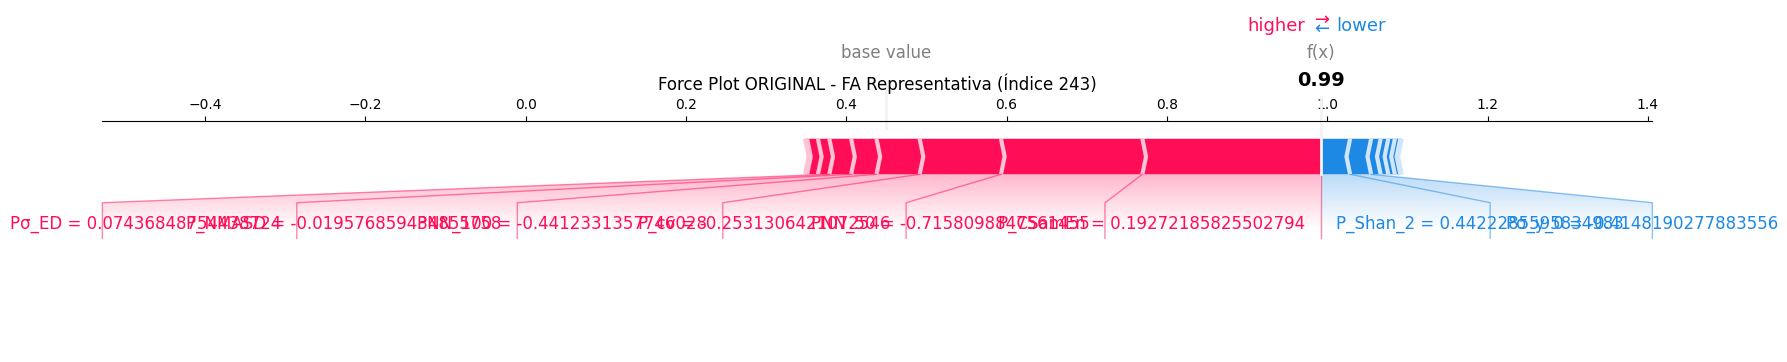


--- Gráfico de Fuerza (Force Plot) REDONDEADO para FA Representativa ---
Force Plot Redondeado guardado en: /content/drive/MyDrive/Doctorado/XAI/Final_XAI_FA/shap_force_plot_rounded_FA_Representativa_243.png


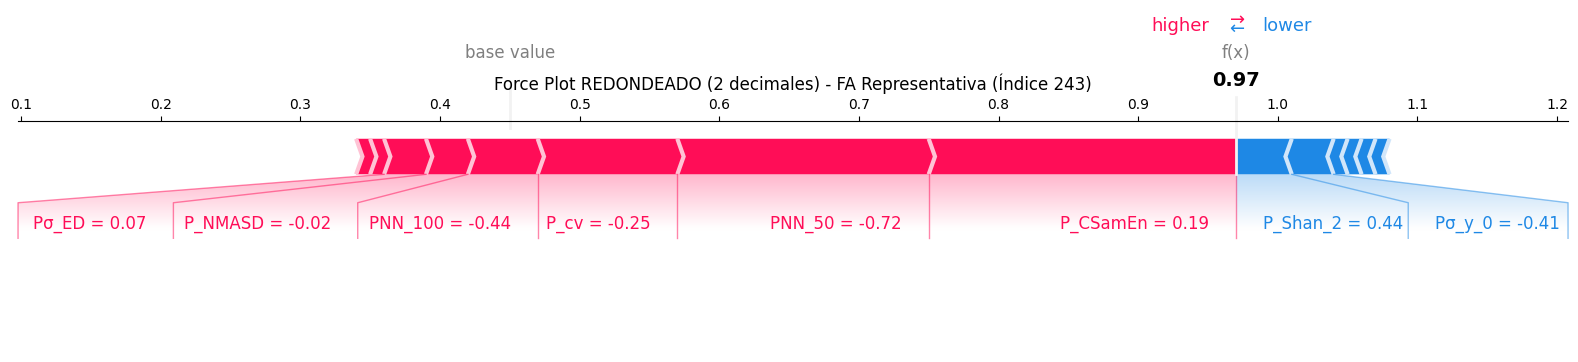


--- Gráfico de Cascada (Waterfall Plot) para FA Representativa ---
Waterfall Plot guardado en: /content/drive/MyDrive/Doctorado/XAI/Final_XAI_FA/shap_waterfall_plot_FA_Representativa_243.png


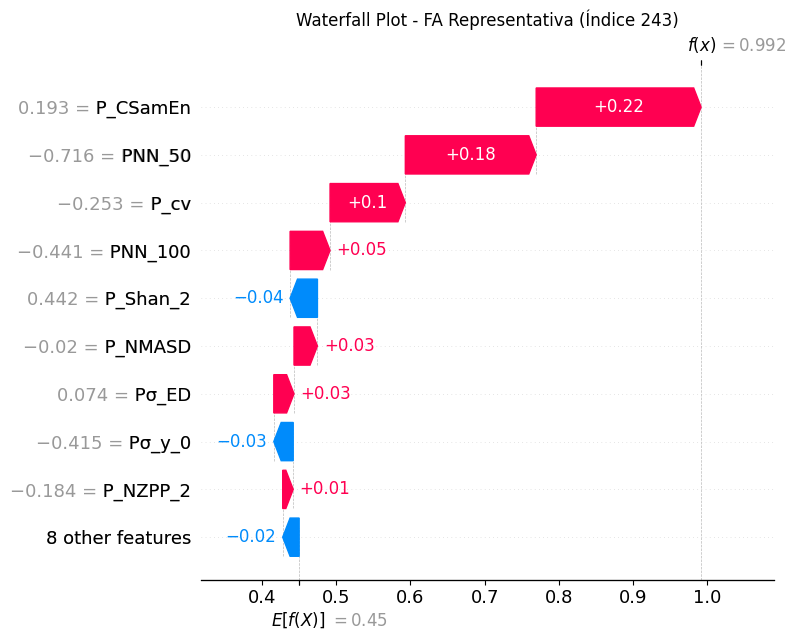


--- GRÁFICOS SHAP PARA INSTANCIA No-FA Representativa (índice en X_test: 271) ---
Valor base (expected_value) para los plots: 0.4499335386955281
Valores SHAP para la instancia: (17,)
Features para la instancia: (17,)

--- Gráfico de Fuerza (Force Plot) ORIGINAL para No-FA Representativa ---
Force Plot Original guardado en: /content/drive/MyDrive/Doctorado/XAI/Final_XAI_FA/shap_force_plot_orig_No-FA_Representativa_271.png


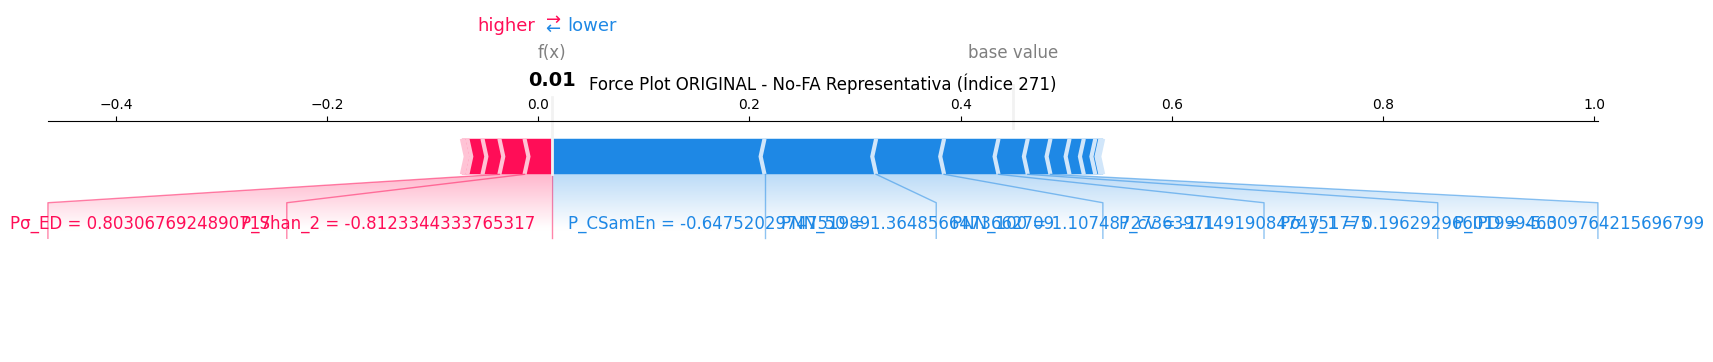


--- Gráfico de Fuerza (Force Plot) REDONDEADO para No-FA Representativa ---
Force Plot Redondeado guardado en: /content/drive/MyDrive/Doctorado/XAI/Final_XAI_FA/shap_force_plot_rounded_No-FA_Representativa_271.png


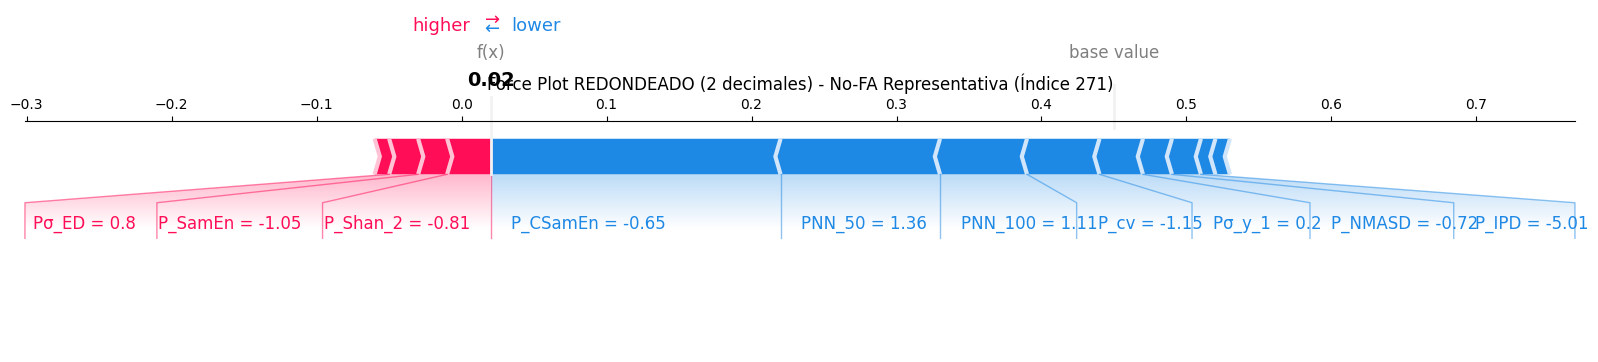


--- Gráfico de Cascada (Waterfall Plot) para No-FA Representativa ---
Waterfall Plot guardado en: /content/drive/MyDrive/Doctorado/XAI/Final_XAI_FA/shap_waterfall_plot_No-FA_Representativa_271.png


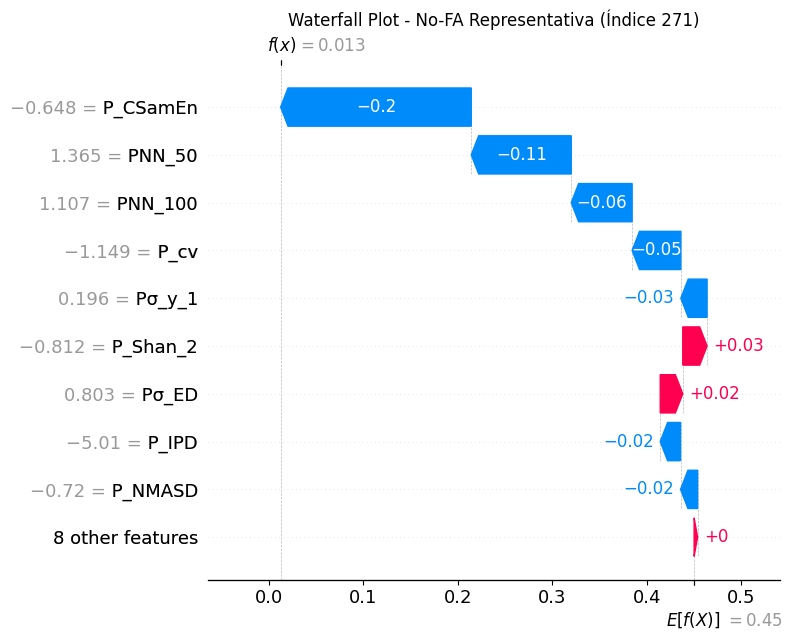

In [19]:
# Explicaciones Locales de SHAP (Para Instancias Seleccionadas)

# Verificar si las variables estan definidas:
if 'explainer' not in locals() or \
   'shap_values_test' not in locals() or \
   'X_test_df_for_shap' not in locals() or \
   'feature_cols' not in locals() or \
   'idx_representative_fa' not in locals() or \
   'idx_representative_nofa' not in locals():
    print("Error: Alguna variable necesaria no está definida.")
else:
    try:
        # --- Función para generar y mostrar plots locales ---
        def generate_local_shap_plots(idx_to_explain, instance_label_text):
            if idx_to_explain is None:
                print(f"No se seleccionó una instancia para {instance_label_text}.")
                return

            if not isinstance(idx_to_explain, int):
                try:
                    idx_to_explain = int(idx_to_explain)
                except ValueError:
                    print(f"Error: No se pudo convertir el índice '{idx_to_explain}' a entero para {instance_label_text}.")
                    return

            print(f"\n--- GRÁFICOS SHAP PARA INSTANCIA {instance_label_text} (índice en X_test: {idx_to_explain}) ---")

            base_value_for_plot = explainer.expected_value
            if isinstance(base_value_for_plot, (list, np.ndarray)) and len(base_value_for_plot) == 2:
                base_value_for_plot = base_value_for_plot[1]
            elif isinstance(base_value_for_plot, (list, np.ndarray)) and len(base_value_for_plot) == 1:
                 base_value_for_plot = base_value_for_plot[0]

            print(f"Valor base (expected_value) para los plots: {base_value_for_plot}")

            current_shap_values = shap_values_test[idx_to_explain,:]
            current_features_series = X_test_df_for_shap.iloc[idx_to_explain,:] # Es una pd.Series

            print(f"Valores SHAP para la instancia: {current_shap_values.shape}")
            print(f"Features para la instancia: {current_features_series.shape}")

            # --- Gráfico de Fuerza (Force Plot) Original ---
            print(f"\n--- Gráfico de Fuerza (Force Plot) ORIGINAL para {instance_label_text} ---")
            # Convertir Series a DataFrame de una fila para el force plot
            current_features_df_original = pd.DataFrame(current_features_series).T
            current_features_df_original.columns = feature_cols

            shap.force_plot(base_value_for_plot,
                            current_shap_values,
                            current_features_df_original,
                            matplotlib=True, show=False)
            plt.title(f"Force Plot ORIGINAL - {instance_label_text} (Índice {idx_to_explain})")
            # Guardar el gráfico (opcional)
            plot_filename_force_orig = os.path.join(OUTPUT_PATH, f'shap_force_plot_orig_{instance_label_text.replace(" ", "_")}_{idx_to_explain}.png')
            plt.savefig(plot_filename_force_orig, dpi=300, bbox_inches='tight')
            print(f"Force Plot Original guardado en: {plot_filename_force_orig}")
            plt.show()


            # --- Gráfico de Fuerza (Force Plot) con Valores Redondeados ---
            print(f"\n--- Gráfico de Fuerza (Force Plot) REDONDEADO para {instance_label_text} ---")
            # Redondear valores de features y SHAP para la visualización
            rounded_features_series = current_features_series.round(2)
            rounded_shap_values = np.round(current_shap_values, 2)

            # Convertir Series redondeada a DataFrame de una fila
            rounded_features_df = pd.DataFrame(rounded_features_series).T
            rounded_features_df.columns = feature_cols

            shap.force_plot(round(base_value_for_plot, 2), # Redondear también el valor base
                            rounded_shap_values,
                            rounded_features_df, # Usar features redondeados
                            matplotlib=True, show=False)
            plt.title(f"Force Plot REDONDEADO (2 decimales) - {instance_label_text} (Índice {idx_to_explain})")
            # Guardar el gráfico
            plot_filename_force_rounded = os.path.join(OUTPUT_PATH, f'shap_force_plot_rounded_{instance_label_text.replace(" ", "_")}_{idx_to_explain}.png')
            plt.savefig(plot_filename_force_rounded, dpi=300, bbox_inches='tight')
            print(f"Force Plot Redondeado guardado en: {plot_filename_force_rounded}")
            plt.show()


            # --- Gráfico de Cascada (Waterfall Plot) ---
            # (Se puede redondear aquí también si se desea, pero el waterfall ya es bastante legible)
            print(f"\n--- Gráfico de Cascada (Waterfall Plot) para {instance_label_text} ---")
            shap.waterfall_plot(shap.Explanation(values=current_shap_values, # Podrías usar rounded_shap_values
                                                 base_values=base_value_for_plot, # Podrías usar round(base_value_for_plot, 2)
                                                 data=current_features_series.values, # Podrías usar rounded_features_series.values
                                                 feature_names=X_test_df_for_shap.columns.tolist()),
                               show=False)
            plt.title(f"Waterfall Plot - {instance_label_text} (Índice {idx_to_explain})")
            plt.tight_layout()
            # Guardar el gráfico (opcional)
            plot_filename_waterfall = os.path.join(OUTPUT_PATH, f'shap_waterfall_plot_{instance_label_text.replace(" ", "_")}_{idx_to_explain}.png')
            plt.savefig(plot_filename_waterfall, dpi=300, bbox_inches='tight')
            print(f"Waterfall Plot guardado en: {plot_filename_waterfall}")
            plt.show()


        # Generar plots para la instancia representativa de FA
        generate_local_shap_plots(idx_representative_fa, "FA Representativa")

        # Generar plots para la instancia representativa de No-FA
        generate_local_shap_plots(idx_representative_nofa, "No-FA Representativa")

    except Exception as e:
        print(f"Un error CRÍTICO inesperado ocurrió en Celda durante la visualización local: {e}")
        traceback.print_exc()

Imagen comparativa completa guardada: /content/drive/MyDrive/Doctorado/XAI/Final_XAI_FA/SHAP_comparativo_FA_vs_NOFA_idx243_271.png


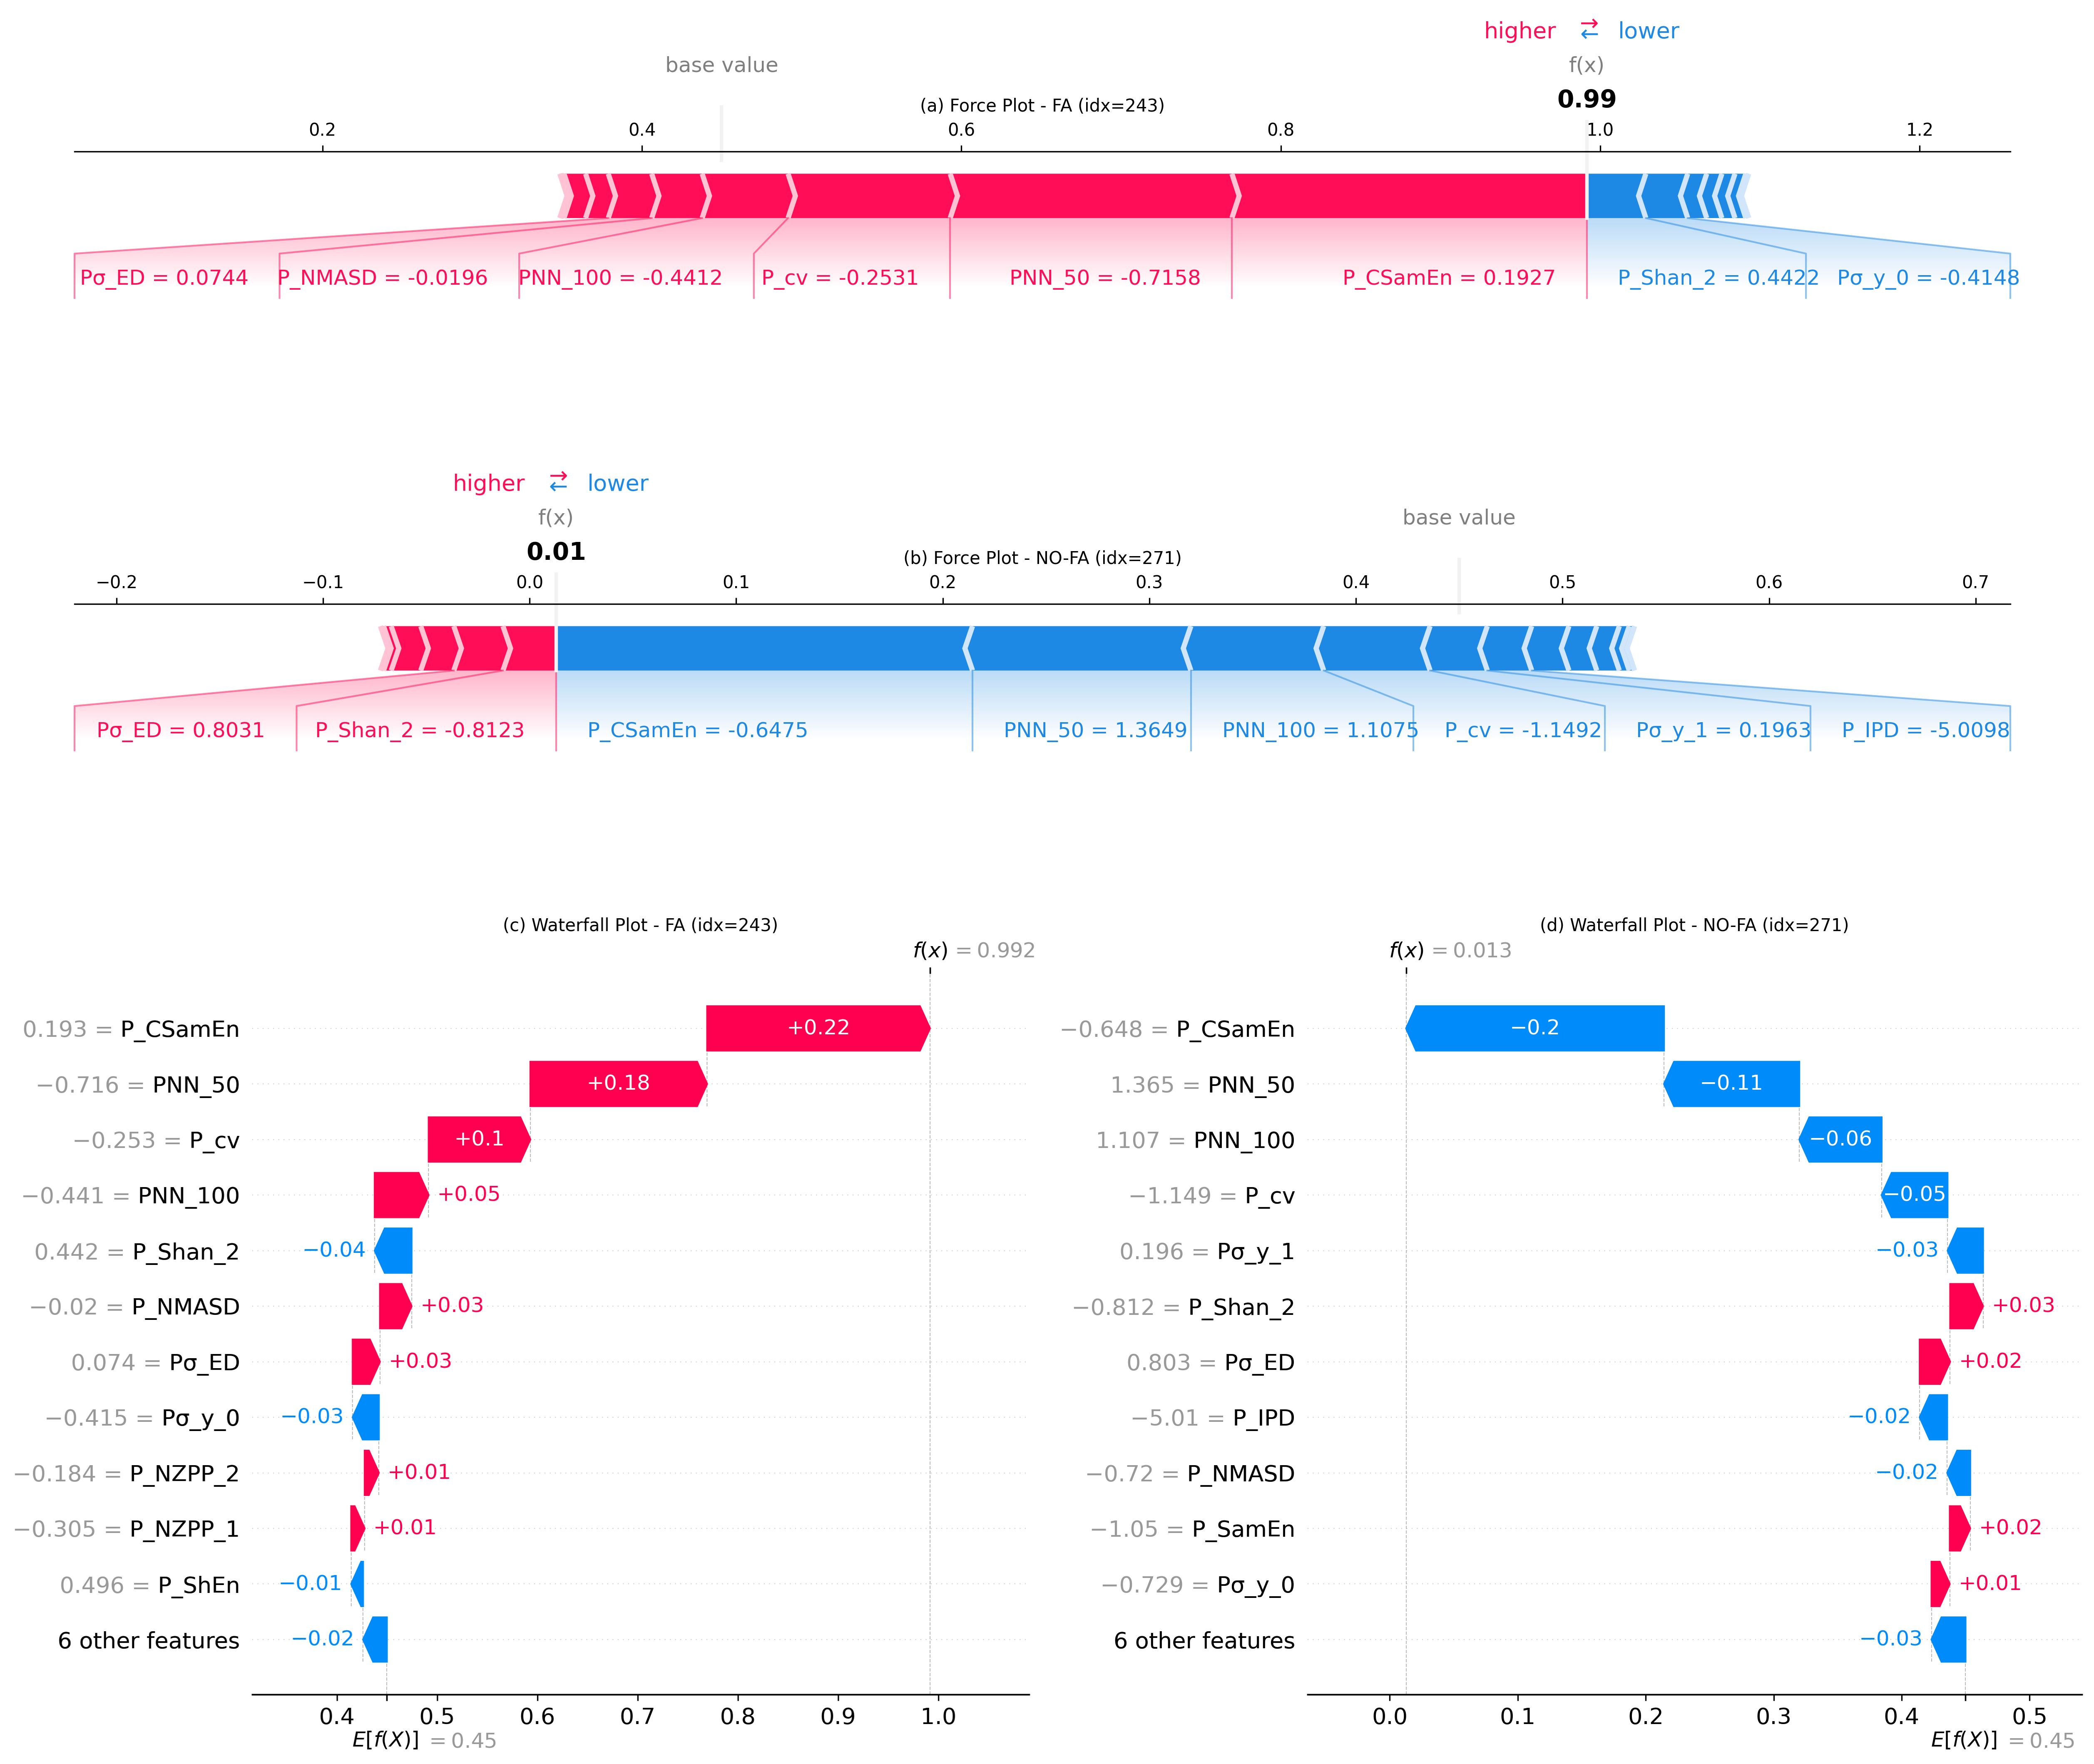

In [20]:
# Combinamos todos los analisis locales en una sola imagen

def create_fresh_plot_images(idx_fa, idx_nofa, output_dir, explainer, shap_values_test, X_test_df_for_shap):
    def generate_force_plot(idx, label_text, ref_tag, filename):
        shap_vals = np.round(shap_values_test[idx], 4)
        features = X_test_df_for_shap.iloc[idx].round(4)
        base_value = explainer.expected_value
        if isinstance(base_value, (list, np.ndarray)) and len(base_value) > 1:
            base_value = base_value[1]
        base_value = round(base_value, 4)

        fig = plt.figure(figsize=(10, 2.5))
        shap.force_plot(
            base_value=base_value,
            shap_values=shap_vals,
            features=features,
            feature_names=features.index,
            matplotlib=True,
            show=False
        )
        plt.title(f"({ref_tag}) Force Plot - {label_text} (idx={idx})", fontsize=10)
        filepath = os.path.join(output_dir, filename)
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        plt.close(fig)
        return filepath

    def generate_waterfall_plot(idx, label_text, ref_tag, filename):
        shap_vals = shap_values_test[idx]
        features = X_test_df_for_shap.iloc[idx]
        base_value = explainer.expected_value
        if isinstance(base_value, (list, np.ndarray)) and len(base_value) > 1:
            base_value = base_value[1]

        fig, ax = plt.subplots(figsize=(10, 5))
        expl = shap.Explanation(
            values=shap_vals,
            base_values=base_value,
            data=features,
            feature_names=features.index
        )
        shap.plots.waterfall(expl, max_display=12, show=False)
        ax = plt.gca()
        ax.set_title(f"({ref_tag}) Waterfall Plot - {label_text} (idx={idx})", fontsize=10, loc='center')

        filepath = os.path.join(output_dir, filename)
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        plt.close(fig)
        return filepath

    # Generar imágenes individuales
    path_force_fa = generate_force_plot(idx_fa, "FA", "a", "temp_force_fa.png")
    path_force_nofa = generate_force_plot(idx_nofa, "NO-FA", "b", "temp_force_nofa.png")
    path_waterfall_fa = generate_waterfall_plot(idx_fa, "FA", "c", "temp_waterfall_fa.png")
    path_waterfall_nofa = generate_waterfall_plot(idx_nofa, "NO-FA", "d", "temp_waterfall_nofa.png")

    # Cargar imágenes
    img_force_fa = Image.open(os.path.join(output_dir, path_force_fa))
    img_force_nofa = Image.open(os.path.join(output_dir, path_force_nofa))
    img_waterfall_fa = Image.open(os.path.join(output_dir, path_waterfall_fa))
    img_waterfall_nofa = Image.open(os.path.join(output_dir, path_waterfall_nofa))

    # Ajuste de tamaños para combinar correctamente
    waterfall_height = max(img_waterfall_fa.height, img_waterfall_nofa.height)
    waterfall_width = max(img_waterfall_fa.width, img_waterfall_nofa.width)
    img_waterfall_fa = img_waterfall_fa.resize((waterfall_width, waterfall_height))
    img_waterfall_nofa = img_waterfall_nofa.resize((waterfall_width, waterfall_height))

    # Combinar force plots en vertical
    force_width = max(img_force_fa.width, img_force_nofa.width)
    force_combined_height = img_force_fa.height + img_force_nofa.height
    force_combined = Image.new("RGB", (force_width, force_combined_height), color=(255, 255, 255))
    force_combined.paste(img_force_fa, (0, 0))
    force_combined.paste(img_force_nofa, (0, img_force_fa.height))

    # Combinar waterfall plots en horizontal
    waterfall_combined = Image.new("RGB", (2 * waterfall_width, waterfall_height), color=(255, 255, 255))
    waterfall_combined.paste(img_waterfall_fa, (0, 0))
    waterfall_combined.paste(img_waterfall_nofa, (waterfall_width, 0))

    # Imagen final: vertical
    final_width = max(force_combined.width, waterfall_combined.width)
    final_height = force_combined.height + waterfall_combined.height
    final_combined = Image.new("RGB", (final_width, final_height), color=(255, 255, 255))
    final_combined.paste(force_combined, ((final_width - force_combined.width) // 2, 0))
    final_combined.paste(waterfall_combined, ((final_width - waterfall_combined.width) // 2, force_combined.height))

    # Guardar imagen final
    output_filename = f"SHAP_comparativo_FA_vs_NOFA_idx{idx_fa}_{idx_nofa}.png"
    combined_path = os.path.join(output_dir, output_filename)
    final_combined.save(combined_path)

    print(f"Imagen comparativa completa guardada: {combined_path}")

    # Mostrar en el notebook
    display(IPImage(filename=combined_path))

# Ejecutar
create_fresh_plot_images(idx_fa=243, idx_nofa=271, output_dir=OUTPUT_PATH, explainer=explainer, shap_values_test=shap_values_test, X_test_df_for_shap=X_test_df_for_shap)


## Force Plot

Este grafico visualiza los valores SHAP como "fuerzas" que empujan para aumentar o disminuir la predicción. Muestra cómo la combinación de los valores de las features de una instancia específica contribuye a mover la predicción desde un valor base (la predicción promedio del modelo) hasta la predicción final para esa instancia.

1. **Valor Base** (`base_value` o `explainer.expected_value`):

  * **Qué es**: Piensa en esto como la "predicción promedio" que el modelo haría si no supiera nada específico sobre esta muestra en particular. Es la predicción media del modelo para la clase positiva (FA = 1) calculada sobre un conjunto de datos de referencia (normalmente, los datos de entrenamiento).
  * **En el Gráfico**: Se muestra como una línea vertical o el punto de inicio de las "fuerzas". Es la línea de salida si ninguna característica tuviera influencia.
  * **Escala**: En nuestro caso, este valor está en la escala de log-odds (logit). Un valor más alto significa una mayor probabilidad inherente (antes de ver los datos de la instancia) de predecir FA. También se puede convertir a una probabilidad para una interpretación más intuitiva (por ejemplo, si el valor base en log-odds es 0.450, la probabilidad base de FA es aproximadamente 61%).

2. **Salida del Modelo** (`f(x)`):

  * **Qué es**: Este es el resultado final de la predicción del modelo para esta muestra específica, después de considerar todas sus características. También se presenta en la misma escala que el valor base (log-odds).
  * **En el Gráfico**: Aparece como un número, usualmente en negrita, al final de la "cadena de fuerzas". Es el punto al que todas las "fuerzas" combinadas han empujado la predicción.
  * **Interpretación**:
    * Si `f(x)` es mayor que el `base_value`, el conjunto de características de esta muestra ha empujado la predicción final a ser más alta que el promedio (lo que significa una mayor probabilidad de ser FA).
    * Si `f(x)` es menor que el `base_value`, las características han empujado la predicción a ser más baja que el promedio (menor probabilidad de ser FA).

3. **Bloques de Colores** (Features y sus Valores SHAP):

  * **Qué son**: El cuerpo principal del gráfico está formado por una serie de bloques o "flechas" de colores, uno al lado del otro. Cada bloque representa la fuerza/impacto de una característica (feature) individual de la muestra que estamos analizando.
  * **Color del Bloque (Dirección de la Fuerza)**:
    * Bloques Rojos (colores cálidos): Representan características que tienen un valor SHAP positivo para esta muestra. Estas son las "fuerzas" que están empujando la predicción hacia arriba (aumentando las log-odds, y por lo tanto la probabilidad, de que sea FA).
    * Bloques Azules (colores fríos): Representan características que tienen un valor SHAP negativo. Estas son las "fuerzas" que están empujando la predicción hacia abajo (disminuyendo las log-odds de FA, o lo que es lo mismo, aumentando las log-odds de No-FA).
  * **Ancho del Bloque (Magnitud de la Fuerza)**:
    * El ancho de cada bloque es directamente proporcional a la magnitud (valor absoluto) del valor SHAP de esa característica para esta muestra.
    * Bloques más anchos indican que esa característica tuvo un mayor impacto (ya sea positivo o negativo) en la predicción de esta muestra específica.
    * Bloques muy delgados significan que esa característica tuvo poco o ningún impacto en esta predicción en particular.
  * **Etiquetas de los Bloques (Información de la Característica)**:
    * Generalmente, dentro o cerca de cada bloque, se muestra el nombre de la característica y su valor real (en nuestro caso, el valor escalado) para esta muestra. Por ejemplo, podrías ver "P_RMSSD = 0.85" o "P_IPD = -1.2". Esto te ayuda a conectar el impacto (valor SHAP) con el valor específico que tomó la feature.

4. **Orden de las Features**:

  * Las características en el force plot no se muestran en un orden aleatorio. SHAP las organiza de una manera que intenta hacer la explicación lo más clara posible.
  * A menudo, están ordenadas por la magnitud de su valor SHAP para esa instancia (las más impactantes primero o más cerca del valor base), o mediante un algoritmo de agrupamiento que junta características con influencias similares o que tienen un impacto secuencial en la predicción.

In [21]:
# Extracción de Datos Numéricos de Instancias SHAP Representativas

# Asegurarse de que las variables necesarias estén definidas:

if 'explainer' not in locals() or \
   'shap_values_test' not in locals() or \
   'X_test_df_for_shap' not in locals() or \
   'feature_cols' not in locals() or \
   'idx_representative_fa' not in locals() or \
   'idx_representative_nofa' not in locals() or \
   'y_pred_proba' not in locals():
    print("Error: Alguna variable necesaria no está definida. Ejecuta celdas anteriores.")
else:
    try:
        # --- Función para extraer y mostrar la información numérica de una instancia ---
        def get_instance_numerical_summary(idx, instance_type_label):
            if idx is None:
                print(f"No se proporcionó un índice para la instancia {instance_type_label}.")
                return None

            if not isinstance(idx, int):
                try:
                    idx = int(idx) # Convertir a entero si es float (ej. 243.0 -> 243)
                except ValueError:
                    print(f"Índice {idx} para {instance_type_label} no es un entero válido.")
                    return None

            print(f"\n--- DATOS NUMÉRICOS PARA INSTANCIA: {instance_type_label} (Índice en X_test: {idx}) ---")

            # 1. Valor base de SHAP (probabilidad)
            base_shap_value = explainer.expected_value
            if isinstance(base_shap_value, (list, np.ndarray)): # Manejar si es una lista/array
                if len(base_shap_value) == 2: # Para clasificación binaria, puede devolver [E[f(X)_clase0], E[f(X)_clase1]]
                    base_shap_value = base_shap_value[1] # Usar el de la clase positiva (FA)
                elif len(base_shap_value) == 1:
                    base_shap_value = base_shap_value[0]
            print(f"Valor_Base_SHAP_Probabilidad: {base_shap_value:.6f}")

            # 2. Probabilidad de FA predicha por el modelo para esta instancia
            predicted_proba_fa_instance = y_pred_proba[idx]
            print(f"Probabilidad_Predicha_FA_Modelo: {predicted_proba_fa_instance:.6f}")

            # 3. Valores SHAP para todas las features de esta instancia
            all_shap_values_for_instance = shap_values_test[idx, :]

            # 4. Suma de todos los valores SHAP para esta instancia
            total_sum_of_shaps = np.sum(all_shap_values_for_instance)
            print(f"Suma_Total_Valores_SHAP: {total_sum_of_shaps:.6f}")

            # 5. Predicción final calculada con SHAP (debería coincidir con la del modelo)
            # Asumiendo que base_shap_value y all_shap_values_for_instance están en la misma escala (probabilidad)
            final_prediction_shap_calc = base_shap_value + total_sum_of_shaps
            print(f"Prediccion_Probabilidad_SHAP_Calculada (Base + SumaSHAP): {final_prediction_shap_calc:.6f}")

            # 6. DataFrame con las Top N features más influyentes, sus valores y sus SHAP values
            instance_feature_values_scaled = X_test_df_for_shap.iloc[idx, :]

            df_instance_details = pd.DataFrame({
                'Feature': feature_cols,
                'Valor_Feature_Escalado': instance_feature_values_scaled.values,
                'Valor_SHAP': all_shap_values_for_instance
            })
            df_instance_details['Abs_Valor_SHAP'] = np.abs(df_instance_details['Valor_SHAP'])
            df_instance_details_sorted_topN = df_instance_details.sort_values(by='Abs_Valor_SHAP', ascending=False).head(7) # Mostrar Top 7 (puedes ajustar N)

            print("\nTop Features Influyentes (ordenadas por |SHAP|):")
            # Imprimir el DataFrame de una manera que sea fácil de copiar
            print(df_instance_details_sorted_topN[['Feature', 'Valor_Feature_Escalado', 'Valor_SHAP']].to_string(index=False))

            return {
                "instance_label": instance_type_label,
                "idx_in_X_test": idx,
                "base_shap_value_probability": base_shap_value,
                "predicted_proba_fa_model": predicted_proba_fa_instance,
                "total_sum_of_shaps": total_sum_of_shaps,
                "prediction_proba_shap_calculated": final_prediction_shap_calc,
                "top_N_features_details": df_instance_details_sorted_topN[['Feature', 'Valor_Feature_Escalado', 'Valor_SHAP']]
            }

        # --- Procesar Instancia FA Representativa ---
        datos_fa_rep = None
        if idx_representative_fa is not None:
            datos_fa_rep = get_instance_numerical_summary(idx_representative_fa, "FA Representativa")
        else:
            print("\nNo se seleccionó una instancia FA representativa.")

        # --- Procesar Instancia No-FA Representativa ---
        datos_nofa_rep = None
        if idx_representative_nofa is not None:
            datos_nofa_rep = get_instance_numerical_summary(idx_representative_nofa, "No-FA Representativa")
        else:
            print("\nNo se seleccionó una instancia No-FA representativa.")

        # Ahora las variables `datos_fa_rep` y `datos_nofa_rep` contienen diccionarios con la información numérica que puedes copiar.
        # Si quieres guardarlos en un formato más estructurado:
        # import json
        # if datos_fa_rep:
        #     with open(os.path.join(OUTPUT_PATH, f'datos_num_FA_rep_{int(idx_representative_fa)}.json'), 'w') as f:
        #         json.dump(datos_fa_rep, f, indent=4, default=lambda x: x.to_dict(orient='records') if isinstance(x, pd.DataFrame) else str(x)) # Manejar DataFrame y otros tipos
        # if datos_nofa_rep:
        #     with open(os.path.join(OUTPUT_PATH, f'datos_num_NoFA_rep_{int(idx_representative_nofa)}.json'), 'w') as f:
        #         json.dump(datos_nofa_rep, f, indent=4, default=lambda x: x.to_dict(orient='records') if isinstance(x, pd.DataFrame) else str(x))

    except Exception as e:
        print(f"Un error CRÍTICO inesperado ocurrió en Celda: {e}")
        traceback.print_exc()


--- DATOS NUMÉRICOS PARA INSTANCIA: FA Representativa (Índice en X_test: 243) ---
Valor_Base_SHAP_Probabilidad: 0.449934
Probabilidad_Predicha_FA_Modelo: 0.991719
Suma_Total_Valores_SHAP: 0.541785
Prediccion_Probabilidad_SHAP_Calculada (Base + SumaSHAP): 0.991719

Top Features Influyentes (ordenadas por |SHAP|):
 Feature  Valor_Feature_Escalado  Valor_SHAP
P_CSamEn                0.192722    0.222292
  PNN_50               -0.715810    0.176385
    P_cv               -0.253131    0.101461
 PNN_100               -0.441233    0.053843
P_Shan_2                0.442229   -0.036851
 P_NMASD               -0.019577    0.031602
   Pσ_ED                0.074368    0.027239

--- DATOS NUMÉRICOS PARA INSTANCIA: No-FA Representativa (Índice en X_test: 271) ---
Valor_Base_SHAP_Probabilidad: 0.449934
Probabilidad_Predicha_FA_Modelo: 0.012750
Suma_Total_Valores_SHAP: -0.437183
Prediccion_Probabilidad_SHAP_Calculada (Base + SumaSHAP): 0.012750

Top Features Influyentes (ordenadas por |SHAP|):
 Featu

## Waterfall Plot

El `waterfall_plot` (gráfico de cascada) es otra manera de visualizar la explicación de una predicción individual. Comparte el mismo objetivo que el `force_plot` (mostrar cómo cada feature contribuye a la predicción), pero lo presenta de una forma diferente.

Este descompone la predicción de una única instancia, mostrando cómo el valor esperado (o base) del modelo se modifica secuencialmente por la contribución (valor SHAP) de cada feature hasta llegar a la predicción final para esa instancia. Esencialmente, te muestra "el camino" desde la predicción promedio hasta la predicción específica. Esto asegura que toda la información necesaria (valores SHAP, valor base, valores de las features y nombres de las features) esté correctamente asociada.

1. **Eje X (Horizontal): Salida del Modelo (en escala log-odds)**

  Este eje representa el valor de la predicción. Comienza en el valor base (`E[f(x)]`) y termina en la predicción final (`f(x)`) para la instancia.
Por el modelo usado, estos valores están en la escala de log-odds de la probabilidad de que la muestra sea FA (clase 1).

2. **Eje Y (Vertical): Features y Valores Base/Final**

* `E[f(x)]` (Valor Esperado / Base Value): La primera barra (generalmente gris o de un color neutro) en la parte inferior del gráfico representa el `explainer.expected_value`. Este es el punto de partida, la predicción promedio en log-odds si no conociéramos ninguna de las features de la instancia.
* Las siguientes barras representan las features. Están ordenadas, comúnmente por la magnitud de su valor SHAP para esa instancia (las más influyentes primero).
* Al lado de cada barra (o sobre ella), se muestra su valor real (o escalado, como es nuestro caso) para esa instancia.
* `f(x)` (Predicción Final):La última barra (generalmente de un color diferente o gris) en la parte derecha del gráfico representa la predicción final del modelo para esta instancia, en la escala de log-odds. Es la suma del valor base y todos los valores SHAP de las features.

3. Barras de Contribución (Los "escalones" de la cascada):

* Cada feature tiene una barra horizontal asociada.
* Color de la Barra: Barras Rojas (o color cálido) indican un valor SHAP positivo y se extienden hacia la derecha (estas features están aumentando el valor de la predicción desde el punto donde la dejó la feature anterior o el valor base si es la primera feature). Mientras que las Barras Azules (o color frío) indican un valor SHAP negativo y se extienden hacia la izquierda (estas features están disminuyendo el valor de la predicción).
* Longitud de la Barra: La longitud de cada barra es directamente proporcional a la magnitud del valor SHAP de esa feature para esta instancia. Features con barras más largas tienen un impacto mayor.
* Conexión de las Barras: Las barras están conectadas secuencialmente. El final de una barra de feature se convierte en el inicio de la siguiente, mostrando el efecto acumulativo.

4. Anotaciones Numéricas:

  A menudo, los valores SHAP exactos (las contribuciones en log-odds) se muestran al final de cada barra de feature (o sobre ella), precedidos por un "+" o un "-".


---

#### Feature Value vs SHAP Value

* **Valor de la Feature (al lado del nombre)**: Es el **"qué"** - el dato crudo o escalado que tiene la muestra para esa característica. Ejemplo: "*El paciente tiene un `P_CSamEn` de 0.192722.*"
* **Valor SHAP (al lado de la barra/bloque o como la "Contribución SHAP")**: Es el **"cuánto y cómo"** - cuánto y en qué dirección ese valor específico de la feature influyó en la predicción del modelo para esta muestra. Ejemplo: "*El hecho de que `P_CSamEn` sea 0.192722 para este paciente, hizo que el modelo aumentara su predicción de probabilidad de FA en 0.222292 (un 22.23% adicional de probabilidad).*"

In [22]:
# Extracción de Datos Numéricos para Waterfall Plot

# Asegurarse de que las variables necesarias estén definidas:

if 'explainer' not in locals() or \
   'shap_values_test' not in locals() or \
   'X_test_df_for_shap' not in locals() or \
   'feature_cols' not in locals() or \
   'idx_representative_fa' not in locals() or \
   'idx_representative_nofa' not in locals() or \
   'y_pred_proba' not in locals():
    print("Error: Alguna variable necesaria no está definida. Ejecuta celdas anteriores.")
else:
    try:
        # --- Función para extraer y mostrar la información numérica para el waterfall ---
        def get_waterfall_numerical_data(idx, instance_type_label, max_display_waterfall=10): # SHAP por defecto muestra 10
            if idx is None:
                print(f"No se proporcionó un índice para la instancia {instance_type_label}.")
                return None

            idx = int(idx) # Asegurar que el índice sea entero

            print(f"\n--- DATOS NUMÉRICOS ESTILO WATERFALL PARA: {instance_type_label} (Índice X_test: {idx}) ---")

            # 1. Valor base de SHAP (probabilidad)
            base_shap_value_prob = explainer.expected_value
            if isinstance(base_shap_value_prob, (list, np.ndarray)):
                base_shap_value_prob = base_shap_value_prob[0] if len(base_shap_value_prob) == 1 else base_shap_value_prob[1]
            print(f"Valor_Base_SHAP_Probabilidad (E[f(X)]): {base_shap_value_prob:.6f}")

            # 2. Probabilidad de FA predicha por el modelo para esta instancia
            predicted_proba_fa_instance = y_pred_proba[idx]
            print(f"Probabilidad_Predicha_FA_Modelo (f(x)): {predicted_proba_fa_instance:.6f}")

            # 3. Valores SHAP y features para esta instancia
            instance_shap_values = shap_values_test[idx, :]
            instance_feature_values_scaled = X_test_df_for_shap.iloc[idx, :]

            # 4. Crear un DataFrame con features, sus valores escalados y sus valores SHAP
            df_instance_full = pd.DataFrame({
                'Feature': feature_cols,
                'Valor_Feature_Escalado': instance_feature_values_scaled.values,
                'Valor_SHAP': instance_shap_values
            })
            df_instance_full['Abs_Valor_SHAP'] = np.abs(df_instance_full['Valor_SHAP'])

            # 5. Ordenar por magnitud de SHAP para identificar las más influyentes
            df_sorted_by_shap = df_instance_full.sort_values(by='Abs_Valor_SHAP', ascending=False)

            # 6. Seleccionar las features para el waterfall plot
            # SHAP waterfall plot muestra las 'max_display - 1' features más importantes
            # y agrupa el resto en "Otras features".
            num_top_features_for_waterfall = max_display_waterfall -1
            df_top_for_waterfall = df_sorted_by_shap.head(num_top_features_for_waterfall)

            # Calcular la suma de SHAP de las features restantes
            shap_sum_others = 0
            if len(df_sorted_by_shap) > num_top_features_for_waterfall:
                df_others = df_sorted_by_shap.iloc[num_top_features_for_waterfall:]
                shap_sum_others = df_others['Valor_SHAP'].sum()

            print("\nFeatures y contribuciones SHAP como aparecerían en un Waterfall Plot (ordenadas por magnitud):")

            waterfall_data_list = []
            # El waterfall comienza con el valor base
            # Luego, cada feature listada cambia la predicción desde el punto anterior.

            current_val = base_shap_value_prob
            waterfall_data_list.append({'Item': 'Valor Base E[f(X)]', 'Contribución SHAP': np.nan, 'Valor Acumulado': current_val, 'Valor_Feature_Escalado': np.nan})

            for _, row in df_top_for_waterfall.iterrows():
                current_val += row['Valor_SHAP']
                waterfall_data_list.append({
                    'Item': row['Feature'],
                    'Contribución SHAP': row['Valor_SHAP'],
                    'Valor Acumulado': current_val,
                    'Valor_Feature_Escalado': row['Valor_Feature_Escalado']
                })

            if shap_sum_others != 0:
                current_val += shap_sum_others
                waterfall_data_list.append({
                    'Item': 'Otras Features',
                    'Contribución SHAP': shap_sum_others,
                    'Valor Acumulado': current_val,
                    'Valor_Feature_Escalado': np.nan
                })

            # El valor acumulado final debe ser la predicción f(x)
            # Esta es una verificación: current_val debería ser muy cercano a predicted_proba_fa_instance
            print(f"Verificación: Último valor acumulado (predicción SHAP): {current_val:.6f}")

            df_waterfall_summary = pd.DataFrame(waterfall_data_list)
            print(df_waterfall_summary.to_string(index=False))

            return {
                "instance_label": instance_type_label,
                "idx_in_X_test": idx,
                "base_shap_value_probability": base_shap_value_prob,
                "predicted_proba_fa_model": predicted_proba_fa_instance,
                "waterfall_data": df_waterfall_summary
            }

        # --- Procesar Instancia FA Representativa ---
        datos_waterfall_fa = None
        if idx_representative_fa is not None:
            datos_waterfall_fa = get_waterfall_numerical_data(idx_representative_fa, "FA Representativa")
        else:
            print("\nNo se seleccionó una instancia FA representativa.")

        # --- Procesar Instancia No-FA Representativa ---
        datos_waterfall_nofa = None
        if idx_representative_nofa is not None:
            datos_waterfall_nofa = get_waterfall_numerical_data(idx_representative_nofa, "No-FA Representativa")
        else:
            print("\nNo se seleccionó una instancia No-FA representativa.")

    except Exception as e:
        print(f"Un error CRÍTICO inesperado ocurrió: {e}")
        traceback.print_exc()


--- DATOS NUMÉRICOS ESTILO WATERFALL PARA: FA Representativa (Índice X_test: 243) ---
Valor_Base_SHAP_Probabilidad (E[f(X)]): 0.449934
Probabilidad_Predicha_FA_Modelo (f(x)): 0.991719

Features y contribuciones SHAP como aparecerían en un Waterfall Plot (ordenadas por magnitud):
Verificación: Último valor acumulado (predicción SHAP): 0.991719
              Item  Contribución SHAP  Valor Acumulado  Valor_Feature_Escalado
Valor Base E[f(X)]                NaN         0.449934                     NaN
          P_CSamEn           0.222292         0.672226                0.192722
            PNN_50           0.176385         0.848611               -0.715810
              P_cv           0.101461         0.950072               -0.253131
           PNN_100           0.053843         1.003915               -0.441233
          P_Shan_2          -0.036851         0.967064                0.442229
           P_NMASD           0.031602         0.998666               -0.019577
             Pσ_ED    

### Análisis de predicción para las instancias representativas

#### Análisis de predicción para la instancia FA Representativa (Índice X_test: 243)

* **Valor Base SHAP (E[f(X)])**: 0.4499 (Probabilidad base de FA)
  * Esto significa que, antes de considerar cualquier feature específica de esta muestra, el modelo tiene una inclinación inicial a predecir FA con aproximadamente **44.99%** de probabilidad.

* **Contribuciones de TODAS las Features para la Instancia 243:**

| Feature                     | Feature\_Value\_Scaled | SHAP\_Value     | Dirección del Empuje |
        | :-------------------------- | :--------------------- | :-------------- | :------------------- |
        | P_cv                        | -0.2531                | 0.1015          | Hacia FA             |
        | P_RMSSD                     | -0.3714                | 0.0048          | Hacia FA             |
        | P_NMASD                     | -0.0196                | 0.0316          | Hacia FA             |
        | P_IPD                       | 0.5640                 | 0.0028          | Hacia FA             |
        | P_SamEn                     | 0.1179                 | -0.0089         | Hacia No-FA          |
        | P_SSamEn                    | 0.2806                 | -0.0022         | Hacia No-FA          |
        | P_CSamEn                    | 0.1927                 | 0.2223          | Hacia FA             |
        | P_ShEn                      | 0.2950                 | 0.0087          | Hacia FA             |
        | P_NZPP_1                    | -0.0504                | 0.0132          | Hacia FA             |
        | P_NZPP_2                    | 0.0172                 | 0.0044          | Hacia FA             |
        | P_NZPP_3                    | -0.0172                | 0.0038          | Hacia FA             |
        | Pσ_y_0                      | -0.3354                | -0.0077         | Hacia No-FA          |
        | Pσ_y_1                      | 0.3168                 | -0.0047         | Hacia No-FA          |
        | Pσ_ED                       | 0.0744                 | 0.0272          | Hacia FA             |
        | PNN_50                      | -0.7158                | 0.1764          | Hacia FA             |
        | PNN_100                     | -0.4412                | 0.0538          | Hacia FA             |
        | P_Shan_2                    | 0.4422                 | -0.0369         | Hacia No-FA          |

* **Suma de TODOS los Valores SHAP para la instancia 243**: 0.541785

* **Predicción Final (f(x)) basada en E[f(X)] + ΣSHAP_values**: 0.991719
  * Probabilidad Predicha de FA (directa del modelo): **99.17%**
  * Probabilidad Predicha de FA (calculada con SHAP): **99.17%**
  * *Ambos valores de probabilidad son idénticos, lo cual es esperado*.

* **Interpretación para FA (Índice 243):** Para esta instancia clasificada correctamente como FA con muy alta confianza (99.17%), la característica `P_CSamEn` (con un valor escalado de 0.19) fue la que más contribuyó positivamente (SHAP: +0.22). Notablemente, `PNN_50` (valor escalado: -0.72, indicando un valor por debajo de la media) también tuvo un fuerte impacto positivo hacia FA (SHAP: +0.18), seguido por `P_cv` (valor escalado: -0.25, SHAP: +0.10). Es interesante que `P_Shan_2`, a pesar de tener un valor escalado positivo (0.44), tuvo una ligera contribución negativa hacia la predicción de FA en este caso específico. Esto subraya cómo el modelo pondera una combinación de factores.


---

#### Análisis de predicción para la instancia No-FA Representativa (Índice X_test: 271)

* **Valor Base SHAP (E[f(X)])**: 0.4499 (Probabilidad base de FA)
  * El modelo parte de la misma probabilidad base del 44.99%.

* **Contribuciones de TODAS las Features para la Instancia 271:**

| Feature                     | Feature\_Value\_Scaled | SHAP\_Value      | Dirección del Empuje |
    | :-------------------------- | :--------------------- | :-------------- | :------------------- |
    | P\_cv                       | -1.1492                | -0.0515         | Hacia No-FA          |
    | P\_RMSSD                    | -0.3522                | 0.0011          | Hacia FA             |
    | P\_NMASD                    | -0.6862                | -0.0117         | Hacia No-FA          |
    | P\_IPD                      | 0.2600                 | -0.0011         | Hacia No-FA          |
    | P\_SamEn                    | -0.6591                | -0.0181         | Hacia No-FA          |
    | P\_SSamEn                   | -0.8820                | 0.0083          | Hacia FA             |
    | P\_CSamEn                   | -0.6475                | -0.2016         | Hacia No-FA          |
    | P\_ShEn                     | -0.7853                | 0.0098          | Hacia FA             |
    | P\_NZPP\_1                  | 0.7379                 | -0.0087         | Hacia No-FA          |
    | P\_NZPP\_2                  | 0.9457                 | -0.0118         | Hacia No-FA          |
    | P\_NZPP\_3                  | 0.8109                 | -0.0056         | Hacia No-FA          |
    | Pσ\_y\_0                    | -0.2178                | -0.0063         | Hacia No-FA          |
    | Pσ\_y\_1                    | 0.1963                 | -0.0277         | Hacia No-FA          |
    | Pσ\_ED                      | 0.8031                 | 0.0238          | Hacia FA             |
    | PNN\_50                     | 1.3649                 | -0.1057         | Hacia No-FA          |
    | PNN\_100                    | 1.1075                 | -0.0643         | Hacia No-FA          |
    | P\_Shan\_2                  | -0.8123                | 0.0257          | Hacia FA             |

* **Suma de TODOS los Valores SHAP para la instancia 271**: -0.437183

* **Predicción Final (f(x)) basada en E[f(X)] + ΣSHAP_values**: 0.012750
  * Probabilidad Predicha de FA (directa del modelo): **1.28%**
  * Probabilidad Predicha de FA (calculada con SHAP): **1.28%**
  * *Ambos valores de probabilidad son idénticos*.

* **Interpretación para No-FA (Índice 271):** Esta instancia fue clasificada correctamente como No-FA con muy alta confianza (probabilidad de FA del 1.28%). La feature `P_CSamEn` (valor escalado: -0.65) fue la que más contribuyó negativamente (SHAP: -0.20), empujando la predicción fuertemente hacia No-FA. Le siguieron `PNN_50` (valor escalado: 1.36, SHAP: -0.11) y `PNN_100` (valor escalado: 1.11, SHAP: -0.06), donde valores altos de estas PNN (porcentaje de diferencias grandes entre latidos) consistentemente apuntaron hacia No-FA. `P_cv` (valor escalado: -1.15) también contribuyó negativamente. En este caso, `P_Shan_2` y `Pσ_ED` tuvieron contribuciones positivas menores hacia FA, pero fueron ampliamente superadas por el impacto de las otras features.


---
### Conclusiones iniciales sobre las Instancias Representativas (Basado en el Análisis Detallado)

El análisis detallado de las predicciones para instancias representativas, utilizando los valores SHAP, ofrece una visión clara de cómo el modelo XGBoost distingue entre Fibrilación Auricular (FA) y ritmo Normal (No-FA). Partiendo de una probabilidad base de FA de aproximadamente el 44.99%, las contribuciones aditivas de los valores SHAP de cada feature ajustan esta probabilidad para llegar a la predicción final del modelo, la cual coincide con la probabilidad calculada mediante la suma de los SHAP.

Para la **instancia representativa de FA (Índice X_test: 243)**, que el modelo clasificó correctamente con una probabilidad de FA del **99.17%**, la suma total de los valores SHAP fue de +0.5418. Las características que más contribuyeron a este incremento significativo fueron `P_CSamEn` (SHAP: +0.2223), `PNN_50` (SHAP: +0.1764), y `P_cv` (SHAP: +0.1015). Es particularmente interesante observar que valores escalados de `PNN_50` (-0.7158) y `P_cv` (-0.2531), que están por debajo de la media de sus respectivas distribuciones (según la escala), tuvieron un fuerte impacto positivo hacia la predicción de FA en esta instancia. Esto sugiere que el modelo ha identificado que, en el contexto de otras features, ciertos patrones de "menor variabilidad" o "menor diferencia entre latidos" en estas métricas pueden ser, de hecho, indicativos de FA, o al menos son tratados como tales por el modelo. En contraste, `P_Shan_2` (valor escalado: 0.4422) tuvo una pequeña contribución negativa (SHAP: -0.0369), mostrando la complejidad de las interacciones que el modelo ha aprendido.

En el caso de la **instancia representativa de No-FA (Índice X_test: 271)**, predicha correctamente con una probabilidad de FA de solo **1.28%**, la suma total de los valores SHAP fue de -0.4372. Las features dominantes que empujaron la predicción fuertemente hacia No-FA (valores SHAP negativos) fueron `P_CSamEn` (SHAP: -0.2016), `PNN_50` (SHAP: -0.1057), y `PNN_100` (SHAP: -0.0643). Aquí, un valor escalado bajo de `P_CSamEn` (-0.6475) y valores altos para `PNN_50` (1.3649) y `PNN_100` (1.1075) fueron interpretados por el modelo como fuertes indicadores de un ritmo No-FA. Aunque features como `P_RMSSD`, `P_SSamEn`, `P_ShEn`, `Pσ_ED` y `P_Shan_2` tuvieron contribuciones positivas menores hacia FA, su impacto fue completamente contrarrestado por el efecto combinado de las features que apuntaban hacia No-FA.

En conclusión, este análisis local demuestra que el modelo utiliza de manera consistente features como `P_CSamEn` y `PNN_50` como diferenciadores clave, aunque la interpretación de sus valores (altos o bajos en la escala normalizada) y su impacto direccional (hacia FA o No-FA) son determinados por el modelo en el contexto multivariado. Las explicaciones SHAP permiten desentrañar estas contribuciones individuales para entender la lógica del modelo en predicciones específicas de alta confianza y revelan cómo el modelo pondera la evidencia de múltiples fuentes para llegar a una decisión.

# 8. Conclusiones

El análisis de explicabilidad (XAI) mediante SHAP sobre el modelo XGBoost entrenado para la detección de Fibrilación Auricular (FA), tras un balanceo del conjunto de datos a 600 muestras por clase (FA y No-FA), ha arrojado insights significativos tanto a nivel global como en la predicción de instancias individuales. El modelo balanceado alcanzó una exactitud del 90.33%, con un rendimiento F1-score equilibrado de 0.90 para ambas clases, indicando una buena capacidad de generalización sin sesgo hacia la clase mayoritaria original.

### Explicabilidad Global del Modelo

1. **Importancia General de Features**: El `summary_plot` de barras global de SHAP (media de los valores SHAP absolutos) y los gráficos de cohortes personalizados revelaron consistentemente que features como `P_CSamEn`, `PNN_50`, `P_cv`, y `PNN_100` se encuentran entre las más influyentes para las decisiones del modelo. El `beeswarm plot` complementó esto mostrando no solo la magnitud sino también la dirección del impacto de los valores de estas features.
2. **Comportamiento por Cohorte (FA Verdadera vs. No-FA Verdadera)**: El análisis de cohortes (tanto el manual como el realizado con `shap.Explanation`) permitió observar la importancia media absoluta de las features para las instancias que eran verdaderamente FA y aquellas que eran verdaderamente No-FA. Esto confirmó que las mismas features tienden a ser importantes para ambas cohortes, pero su magnitud de impacto puede variar, subrayando su poder discriminatorio.
3. **Comportamiento Contraintuitivo de `PNN_50`**: El `beeswarm plot`, y posteriormente el análisis local, confirmaron que el modelo aprendió una relación "inversa" para `PNN_50` en comparación con la expectativa teórica (donde `PNN_50` alto se asocia con FA). En el modelo, valores más bajos de `PNN_50` (escalados) tendieron a empujar la predicción hacia FA, y valores más altos hacia No-FA. Esto resalta la capacidad del modelo para encontrar patrones discriminatorios complejos, posiblemente influenciados por el preprocesamiento (especialmente la eliminación de ectópicos) y las interacciones multivariadas con otras features como `P_CSamEn`.

### Explicabilidad de Instancias Individuales Representativas

El análisis detallado de instancias representativas (una FA correctamente predicha con alta confianza y una No-FA correctamente predicha con alta confianza) mediante los `waterfall plots `y `force plots` ilustró la mecánica aditiva de SHAP:

1. **Instancia FA Representativa (ej. Índice 243, Predicción ~99.17% FA)**: Se observó cómo el modelo partió de una probabilidad base de FA (~45%) y las contribuciones positivas de features clave como `P_CSamEn` (+0.22), `PNN_50` (+0.18, a pesar de un valor escalado bajo de -0.72), y `P_cv` (+0.10) elevaron secuencialmente la probabilidad hasta el valor final. Este caso destacó cómo el modelo puede interpretar valores de features por debajo de la media (escalados negativamente) como fuertes indicadores de FA en el contexto adecuado.
2. **Instancia No-FA Representativa (ej. Índice 271, Predicción ~1.28% FA)**: De manera similar, partiendo de la misma base, features como `P_CSamEn` (SHAP -0.20 con un valor escalado bajo de -0.65), `PNN_50` (SHAP -0.11 con un valor escalado alto de 1.36), y `PNN_100` (SHAP -0.06) empujaron decisivamente la predicción hacia No-FA.

En ambos casos, la suma de los valores SHAP más la probabilidad base SHAP coincidió exactamente con la probabilidad predicha por el modelo, validando la consistencia de las explicaciones. El redondeo de valores en los `force plots` adicionales mejoró la legibilidad para la interpretación de estas contribuciones.


### Valor General del Análisis SHAP

Este estudio de XAI ha sido fundamental para:

* Confirmar la relevancia de ciertas features de HRV y Poincaré en la discriminación de FA.
* Entender la magnitud y dirección del impacto de cada feature, tanto globalmente como para predicciones específicas.
* Descubrir y comenzar a investigar relaciones aprendidas por el modelo que pueden ser contraintuitivas si se analizan las features de forma aislada (como `PNN_50`), lo que sugiere la importancia de las interacciones y el contexto multivariado.
* Proporcionar una base transparente para confiar en las predicciones del modelo y para comunicar su funcionamiento interno.

---
# 9. Posibles Mejoras y Trabajo Futuro

Aunque el análisis actual proporciona insights valiosos, existen varias vías para profundizar la investigación y potencialmente mejorar el rendimiento y la interpretabilidad del modelo:

1. **Validación Cruzada Robusta:**

  Implementar una estrategia de validación cruzada (ej., `StratifiedKFold` con 5 folds) durante el entrenamiento y la evaluación del modelo XGBoost. Esto proporcionará una estimación más robusta y fiable del rendimiento del modelo, especialmente importante dado el tamaño del dataset después del undersampling (1200 muestras). Las métricas obtenidas serían menos dependientes de una única división aleatoria train/test.

2. **Optimización de Hiperparámetros:**

  Realizar una búsqueda sistemática de los mejores hiperparámetros para el `XGBClassifier` (ej., `n_estimators`, `max_depth`, `learning_rate`, `gamma`, `subsample`, `colsample_bytree`) utilizando herramientas como `GridSearchCV` o `RandomizedSearchCV` en conjunto con la validación cruzada. Esto podría mejorar las métricas de rendimiento del modelo.

3. **Exploración de Diferentes Técnicas de Balanceo de Clases:**

  * Comparar los resultados del undersampling manual actual con otras técnicas para manejar el desbalance de clases original. Esto incluye:
    * `scale_pos_weight` en XGBoost: Aplicarlo al dataset original desbalanceado.
    * Técnicas de Oversampling (ej., SMOTE, ADASYN): Para generar muestras sintéticas de la clase minoritaria (FA).
    * Combinaciones de Oversampling y Undersampling.
  * Evaluar cuál estrategia produce el mejor balance entre rendimiento y generalización.

4. **Análisis de Interacción de Features con SHAP:**

  * Profundizar en el comportamiento de features como `PNN_50`. Utilizar `shap.dependence_plot(feature1, shap_values, features, interaction_index=feature2)` para visualizar cómo el impacto de `PNN_50` cambia en función de los valores de otra feature importante (ej., `P_CSamEn`).
  * Considerar el uso de `shap.plots.interaction_values()` para cuantificar y visualizar los efectos de interacción de segundo orden.

5. **Investigación de "Otras Features" en Waterfall Plots:**

  Si la barra "Otras Features" en los `waterfall_plots` consistentemente tiene una magnitud significativa, podría ser útil aumentar el parámetro `max_display` en el plot para desglosar más features individualmente y entender mejor esas contribuciones menores pero acumulativas.

6. **Evaluación en un Conjunto de Datos Externo o "Hold-Out":**

  Si es posible, evaluar el modelo final en un conjunto de datos completamente independiente (que no se haya usado en el entrenamiento, validación o selección de features) para obtener una medida imparcial de su capacidad de generalización a nuevos datos no vistos.

7. **Refinamiento del Feature Engineering y Selección:**

  Basado en los insights de SHAP (features consistentemente importantes vs. aquellas con poco impacto o comportamiento muy errático), se podría reconsiderar el conjunto de features. *¿Hay features redundantes? ¿Podrían crearse nuevas features combinando las existentes para capturar mejor las interacciones?*

8. **Comparación con Otros Modelos Explicables:**

  Explorar otros algoritmos de modelado (ej., Regresión Logística con regularización, Random Forest) y comparar tanto su rendimiento como la facilidad y naturaleza de sus explicaciones (ej., coeficientes para LR, feature importance para RF, y SHAP para todos).

9. **Desarrollo de una Interfaz Interactiva para XAI (A Largo Plazo):**

  Para una mayor utilidad clínica o para facilitar la exploración por parte de expertos del dominio no técnicos, se podría considerar el desarrollo de un dashboard simple (usando herramientas como Dash o Streamlit) donde se puedan cargar datos, obtener predicciones y visualizar explicaciones SHAP de forma interactiva.